In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl

In [ ]:
data = pd.read_csv("/content/trained_data.csv")


In [ ]:
data

name    datetime  tempmax  tempmin  temp  feelslikemax  \
0    ottawa, canada  2021-08-14     23.7     17.1  20.8          23.7   
1    ottawa, canada  2021-08-15     23.8     10.3  17.8          23.8   
2    ottawa, canada  2021-08-16     25.7     10.7  19.1          25.7   
3    ottawa, canada  2021-08-17     22.7     14.5  19.3          22.7   
4    ottawa, canada  2021-08-18     28.8     21.1  24.0          30.4   
..              ...         ...      ...      ...   ...           ...   
986  ottawa, canada  2024-04-26     14.2     -1.9   7.1          14.2   
987  ottawa, canada  2024-04-27     19.1      2.8  10.4          19.1   
988  ottawa, canada  2024-04-28     20.1      9.8  14.3          20.1   
989  ottawa, canada  2024-04-29     11.8      5.7   8.8          11.8   
990  ottawa, canada  2024-04-30      8.8      5.9   7.3           5.9   

     feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0            17.1       20.8  12.0      58.5  ...         19.1        9   
1            10.3       17.8   9.4      61.9  ...         18.6        8   
2            10.7       19.1  11.0      62.1  ...         16.6        7   
3            14.5       19.3  16.7      85.1  ...          5.5        5   
4            21.1       24.5  20.8      83.7  ...          8.7        4   
..            ...        ...   ...       ...  ...          ...      ...   
986          -1.9        7.0  -4.6      48.1  ...         24.0        9   
987           0.2        9.6   1.8      58.5  ...         10.8        6   
988           7.9       14.0   9.7      74.9  ...         12.2        8   
989           2.3        7.0   2.0      62.9  ...         12.1        5   
990           2.8        4.3   5.3      87.6  ...          4.7        3   

     severerisk              sunrise               sunset  moonphase  \
0           NaN  2021-08-14T06:02:41  2021-08-14T20:11:17       0.22   
1           NaN  2021-08-15T06:03:53  2021-08-15T20:09:40       0.25   
2           NaN  2021-08-16T06:05:06  2021-08-16T20:08:03       0.29   
3           NaN  2021-08-17T06:06:18  2021-08-17T20:06:24       0.33   
4           NaN  2021-08-18T06:07:31  2021-08-18T20:04:44       0.36   
..          ...                  ...                  ...        ...   
986        10.0  2024-04-26T05:57:58  2024-04-26T20:03:52       0.59   
987        10.0  2024-04-27T05:56:24  2024-04-27T20:05:09       0.63   
988        10.0  2024-04-28T05:54:50  2024-04-28T20:06:25       0.67   
989        10.0  2024-04-29T05:53:18  2024-04-29T20:07:41       0.70   
990        10.0  2024-04-30T05:51:47  2024-04-30T20:08:57       0.74   

                                     conditions  \
0                        Rain, Partially cloudy   
1                                         Clear   
2                              Partially cloudy   
3                        Rain, Partially cloudy   
4                                      Overcast   
..                                          ...   
986  Snow, Rain, Freezing Drizzle/Freezing Rain   
987                      Rain, Partially cloudy   
988                              Rain, Overcast   
989                              Rain, Overcast   
990                              Rain, Overcast   

                                           description               icon  \
0    Partly cloudy throughout the day with early mo...               rain   
1                 Clear conditions throughout the day.          clear-day   
2                    Partly cloudy throughout the day.  partly-cloudy-day   
3    Partly cloudy throughout the day with morning ...               rain   
4                     Cloudy skies throughout the day.             cloudy   
..                                                 ...                ...   
986  Clear conditions throughout the day with after...               rain   
987        Partly cloudy throughout the day with rain.               rain   
988         Cloudy skies throughout the day with rain.            

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              991 non-null    object 
 1   datetime          991 non-null    object 
 2   tempmax           991 non-null    float64
 3   tempmin           991 non-null    float64
 4   temp              991 non-null    float64
 5   feelslikemax      991 non-null    float64
 6   feelslikemin      991 non-null    float64
 7   feelslike         991 non-null    float64
 8   dew               991 non-null    float64
 9   humidity          991 non-null    float64
 10  precip            991 non-null    float64
 11  precipprob        991 non-null    int64  
 12  precipcover       991 non-null    float64
 13  preciptype        721 non-null    object 
 14  snow              991 non-null    float64
 15  snowdepth         991 non-null    float64
 16  windgust          991 non-null    float64
 1

In [ ]:
# target -> temp
columns = ["datetime","temp","humidity","precip","cloudcover","snow","windspeed","sealevelpressure"]
data = data[columns]
data

datetime  temp  humidity  precip  cloudcover  snow  windspeed  \
0    2021-08-14  20.8      58.5   0.209        44.1   0.0       26.1   
1    2021-08-15  17.8      61.9   0.000        18.4   0.0       11.6   
2    2021-08-16  19.1      62.1   0.000        45.6   0.0       11.0   
3    2021-08-17  19.3      85.1   0.005        84.2   0.0        9.5   
4    2021-08-18  24.0      83.7   0.000        96.1   0.0       11.9   
..          ...   ...       ...     ...         ...   ...        ...   
986  2024-04-26   7.1      48.1   0.023         5.1   0.0       11.6   
987  2024-04-27  10.4      58.5   1.566        72.6   0.0       27.3   
988  2024-04-28  14.3      74.9   5.170        92.5   0.0       24.0   
989  2024-04-29   8.8      62.9   1.413        92.7   0.0       21.4   
990  2024-04-30   7.3      87.6   9.116       100.0   0.0       28.1   

     sealevelpressure  
0              1017.7  
1              1023.7  
2              1021.9  
3              1019.3  
4              1019.2  
..                ...  
986            1031.4  
987            1025.1  
988            1016.1  
989            1020.5  
990            1014.8  

[991 rows x 8 columns]

In [ ]:
data["datetime"] = pd.to_datetime(data["datetime"])

<ipython-input-6-d5b5a2915387>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["datetime"] = pd.to_datetime(data["datetime"])


In [ ]:
data.isnull().sum()

datetime            0
temp                0
humidity            0
precip              0
cloudcover          0
snow                0
windspeed           0
sealevelpressure    0
dtype: int64

# Data Analysis


In [ ]:
data.describe()

datetime        temp    humidity      precip  cloudcover  \
count                  991  991.000000  991.000000  991.000000  991.000000   
mean   2022-12-22 00:00:00    6.838244   72.281130    2.438978   61.125631   
min    2021-08-14 00:00:00  -24.900000   31.300000    0.000000    1.800000   
25%    2022-04-18 12:00:00   -1.250000   65.500000    0.000000   43.050000   
50%    2022-12-22 00:00:00    6.600000   73.600000    0.031000   62.800000   
75%    2023-08-26 12:00:00   17.000000   80.950000    1.589000   82.500000   
max    2024-04-30 00:00:00   26.500000   99.500000   70.617000  100.000000   
std                    NaN   10.992940   12.484472    6.127669   24.457034   

             snow   windspeed  sealevelpressure  
count  991.000000  991.000000        991.000000  
mean     0.512916   20.800807       1015.559738  
min      0.000000    4.900000        985.900000  
25%      0.000000   15.800000       1010.300000  
50%      0.000000   20.300000       1015.400000  
75%      0.100000   25.500000       1020.900000  
max     12.900000   53.000000       1039.600000  
std      1.440726    7.162361          8.043114

In [ ]:
data_vis = data.set_index('datetime')

In [ ]:
data_vis

temp  humidity  precip  cloudcover  snow  windspeed  \
datetime                                                          
2021-08-14  20.8      58.5   0.209        44.1   0.0       26.1   
2021-08-15  17.8      61.9   0.000        18.4   0.0       11.6   
2021-08-16  19.1      62.1   0.000        45.6   0.0       11.0   
2021-08-17  19.3      85.1   0.005        84.2   0.0        9.5   
2021-08-18  24.0      83.7   0.000        96.1   0.0       11.9   
...          ...       ...     ...         ...   ...        ...   
2024-04-26   7.1      48.1   0.023         5.1   0.0       11.6   
2024-04-27  10.4      58.5   1.566        72.6   0.0       27.3   
2024-04-28  14.3      74.9   5.170        92.5   0.0       24.0   
2024-04-29   8.8      62.9   1.413        92.7   0.0       21.4   
2024-04-30   7.3      87.6   9.116       100.0   0.0       28.1   

            sealevelpressure  
datetime                      
2021-08-14            1017.7  
2021-08-15            1023.7  
2021-08-16            1021.9  
2021-08-17            1019.3  
2021-08-18            1019.2  
...                      ...  
2024-04-26            1031.4  
2024-04-27            1025.1  
2024-04-28            1016.1  
2024-04-29            1020.5  
2024-04-30            1014.8  

[991 rows x 7 columns]

In [ ]:
data

datetime  temp  humidity  precip  cloudcover  snow  windspeed  \
0   2021-08-14  20.8      58.5   0.209        44.1   0.0       26.1   
1   2021-08-15  17.8      61.9   0.000        18.4   0.0       11.6   
2   2021-08-16  19.1      62.1   0.000        45.6   0.0       11.0   
3   2021-08-17  19.3      85.1   0.005        84.2   0.0        9.5   
4   2021-08-18  24.0      83.7   0.000        96.1   0.0       11.9   
..         ...   ...       ...     ...         ...   ...        ...   
986 2024-04-26   7.1      48.1   0.023         5.1   0.0       11.6   
987 2024-04-27  10.4      58.5   1.566        72.6   0.0       27.3   
988 2024-04-28  14.3      74.9   5.170        92.5   0.0       24.0   
989 2024-04-29   8.8      62.9   1.413        92.7   0.0       21.4   
990 2024-04-30   7.3      87.6   9.116       100.0   0.0       28.1   

     sealevelpressure  
0              1017.7  
1              1023.7  
2              1021.9  
3              1019.3  
4              1019.2  
..                ...  
986            1031.4  
987            1025.1  
988            1016.1  
989            1020.5  
990            1014.8  

[991 rows x 8 columns]

# Data Viz

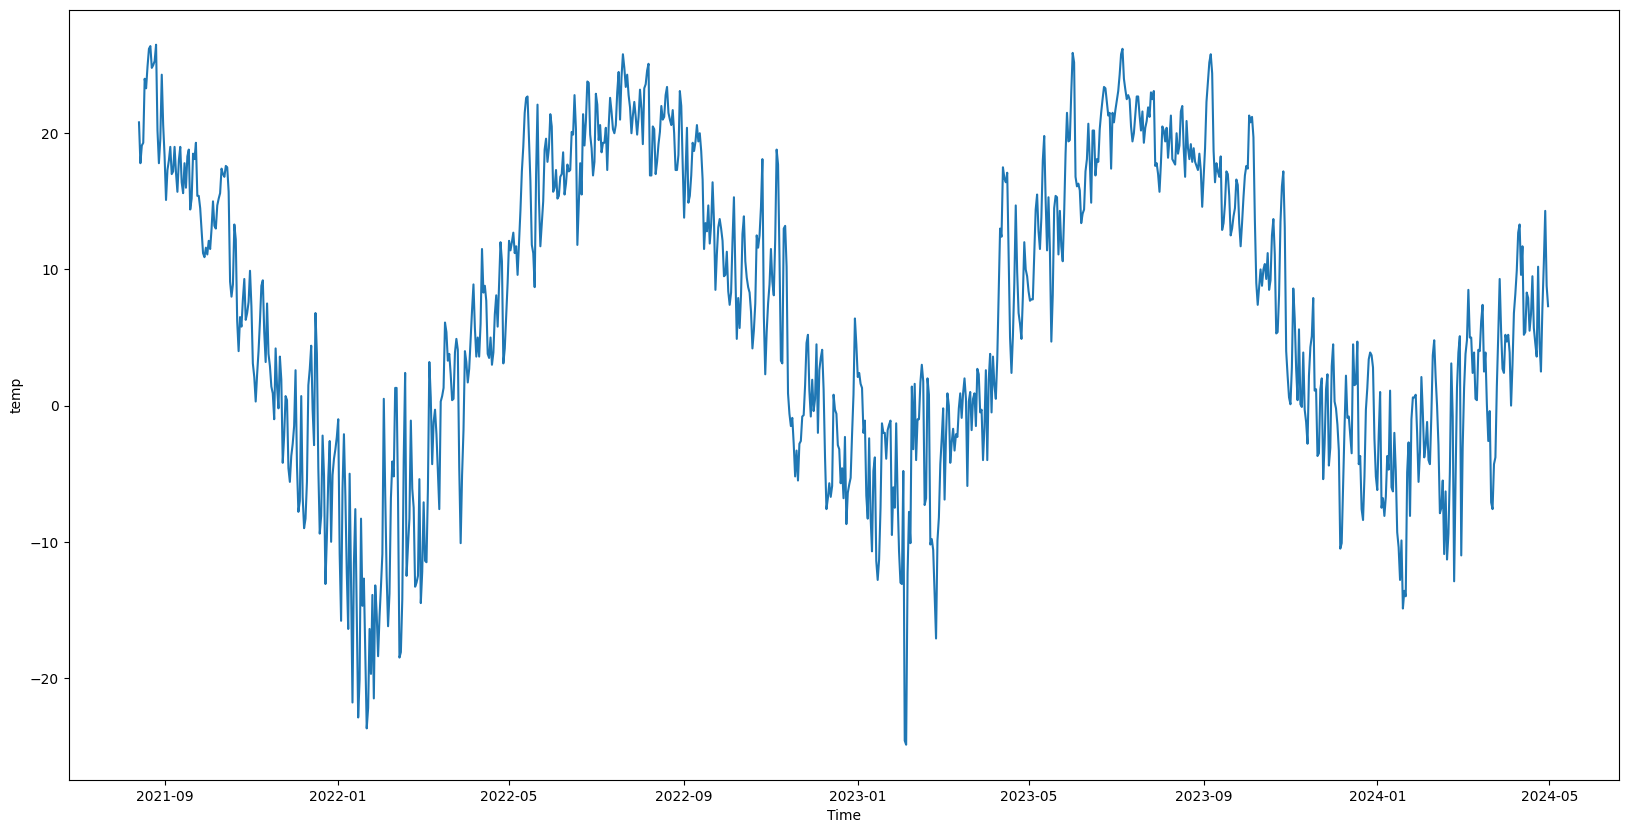

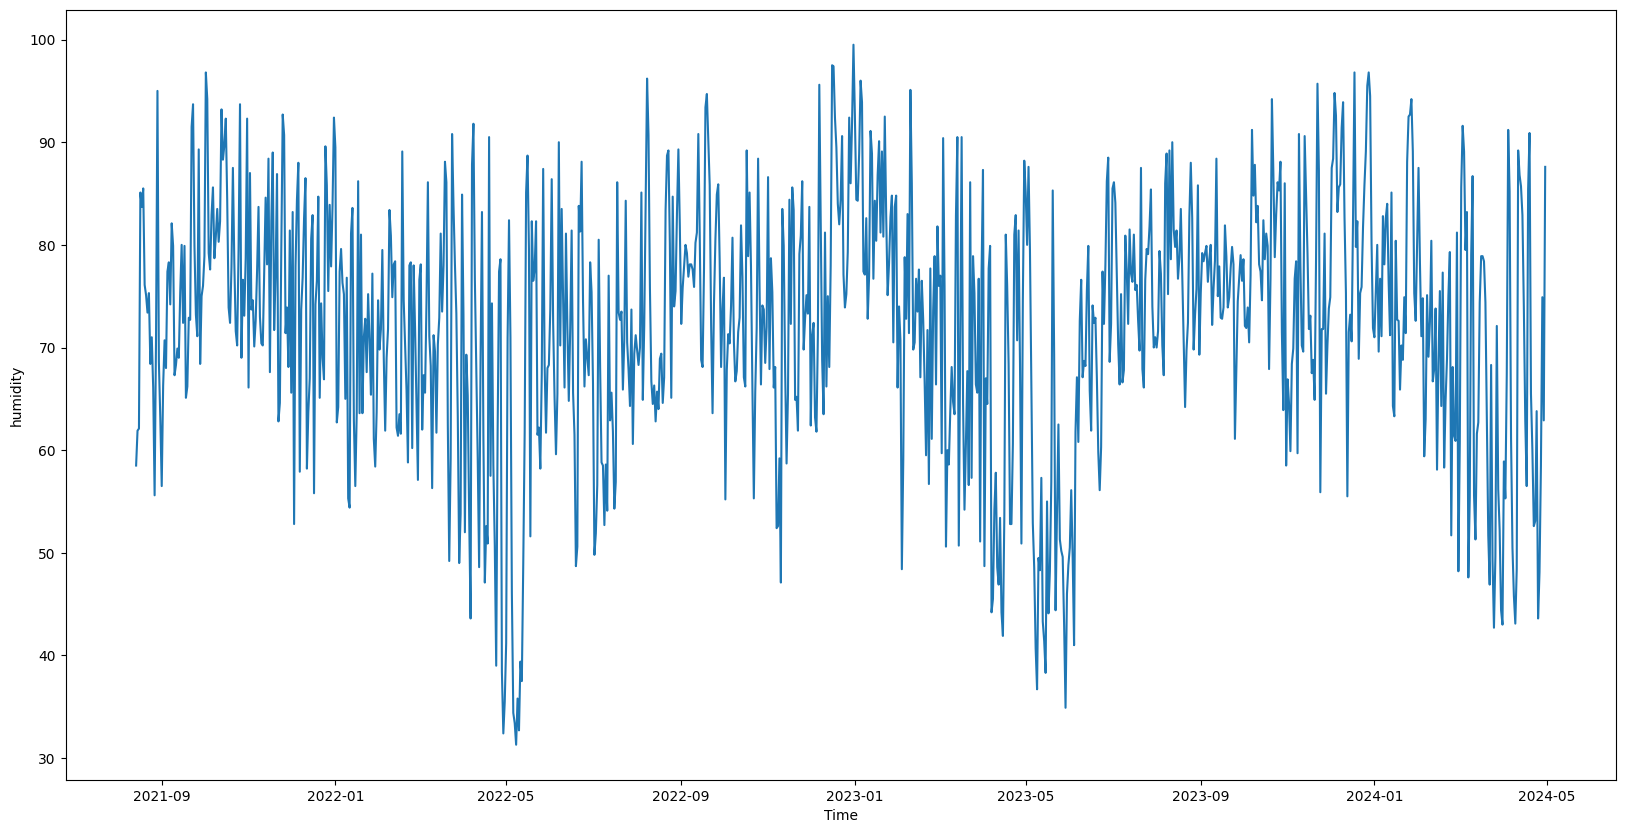

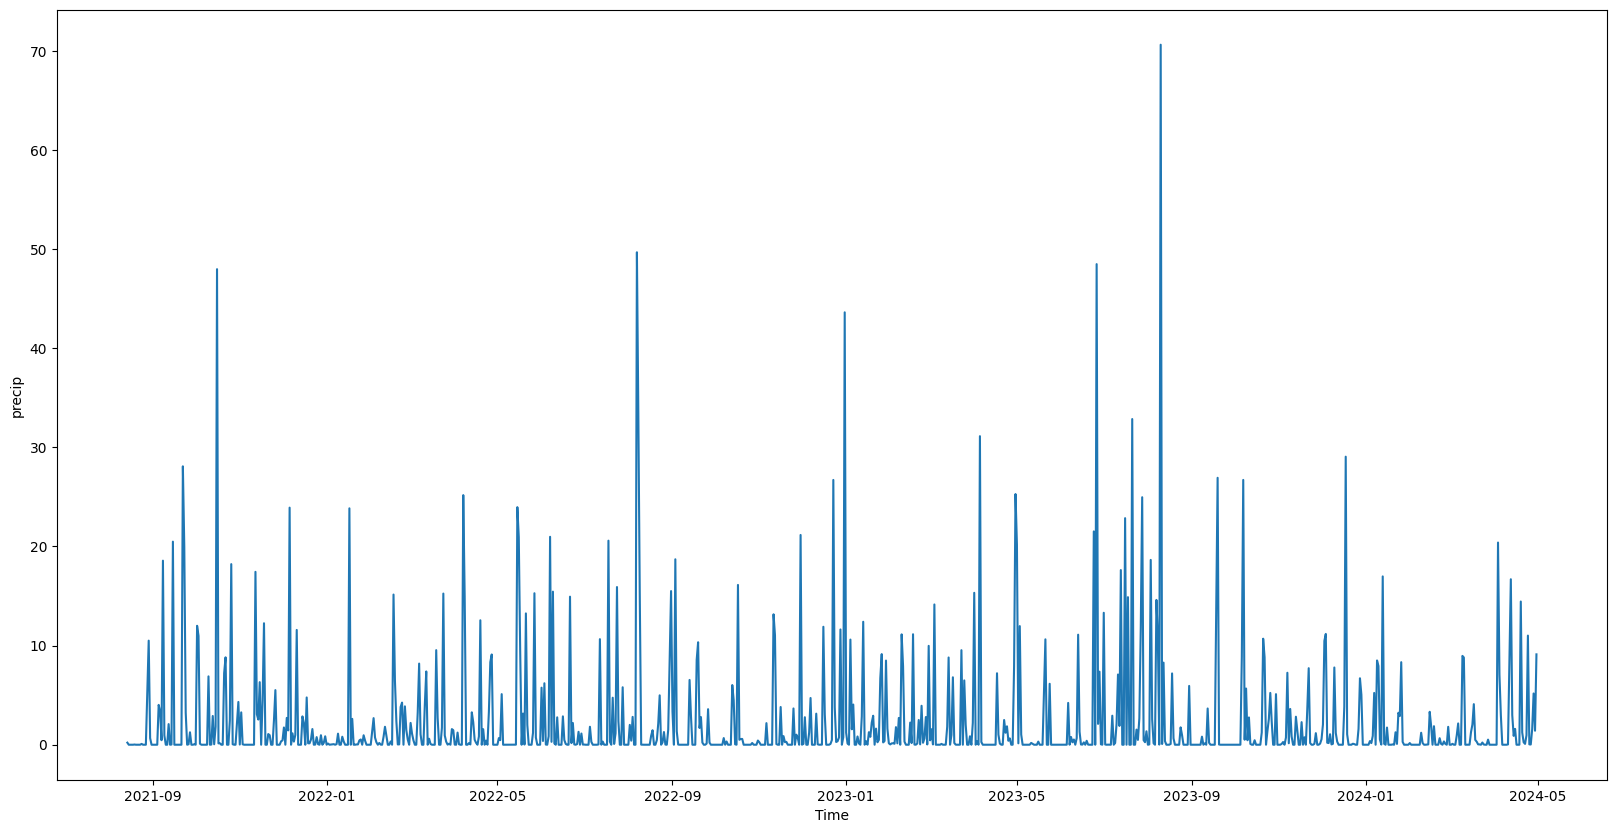

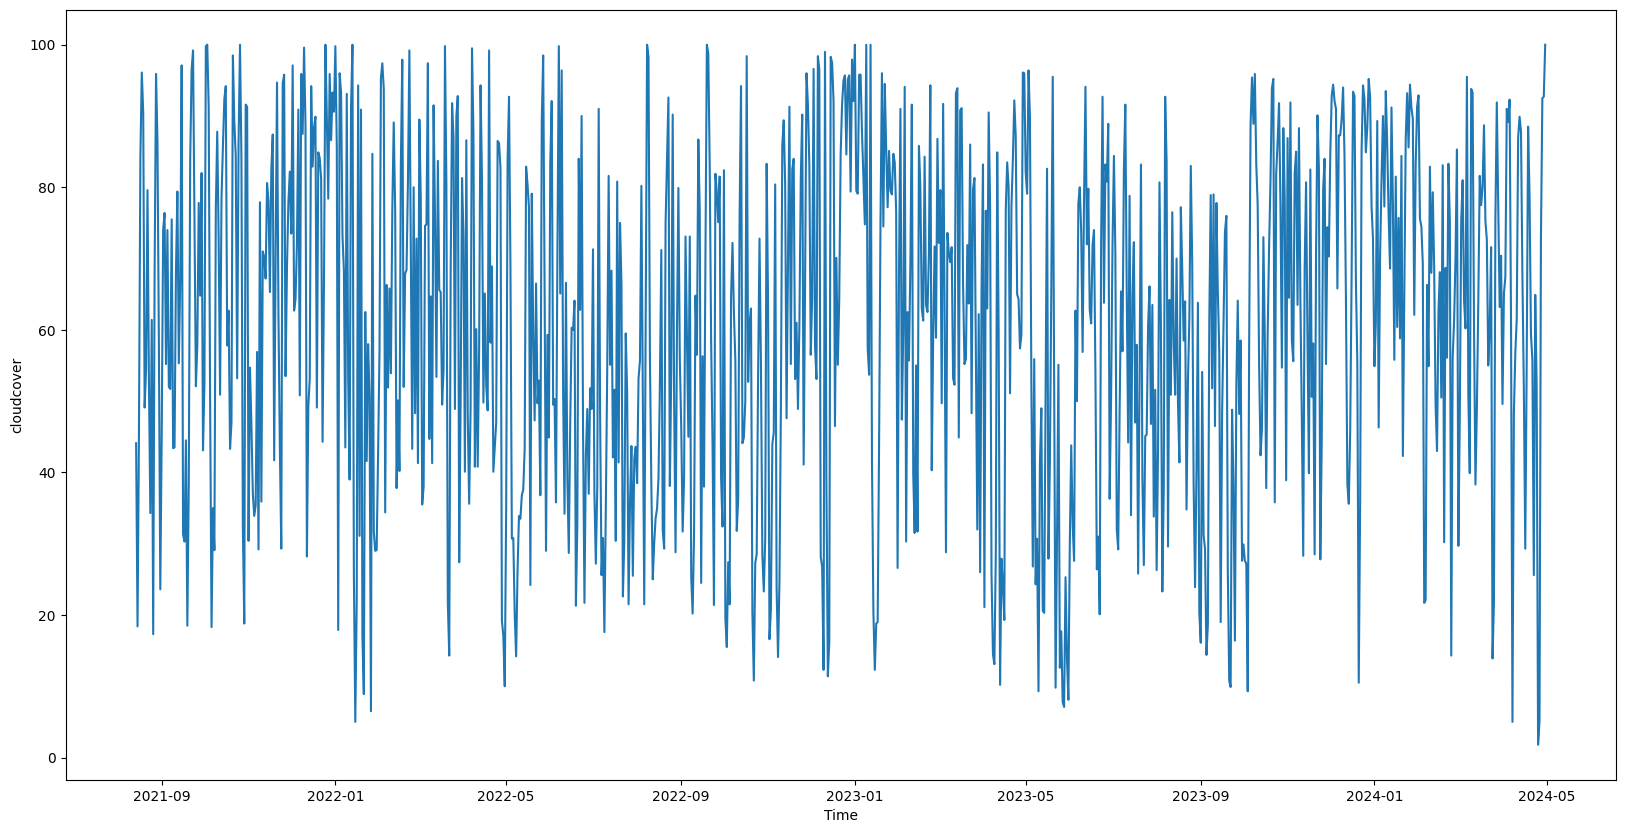

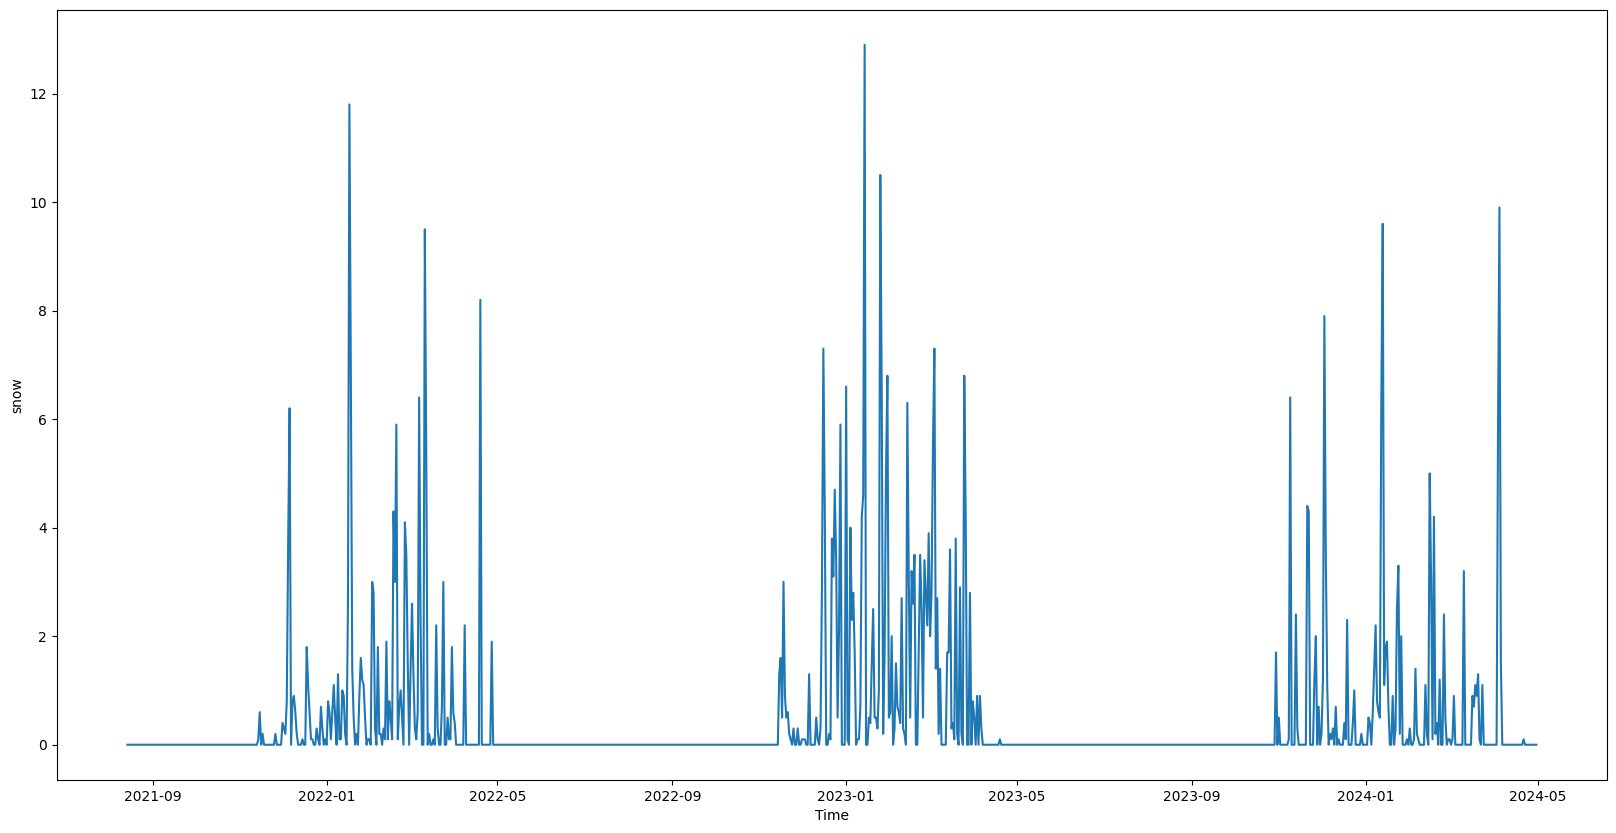

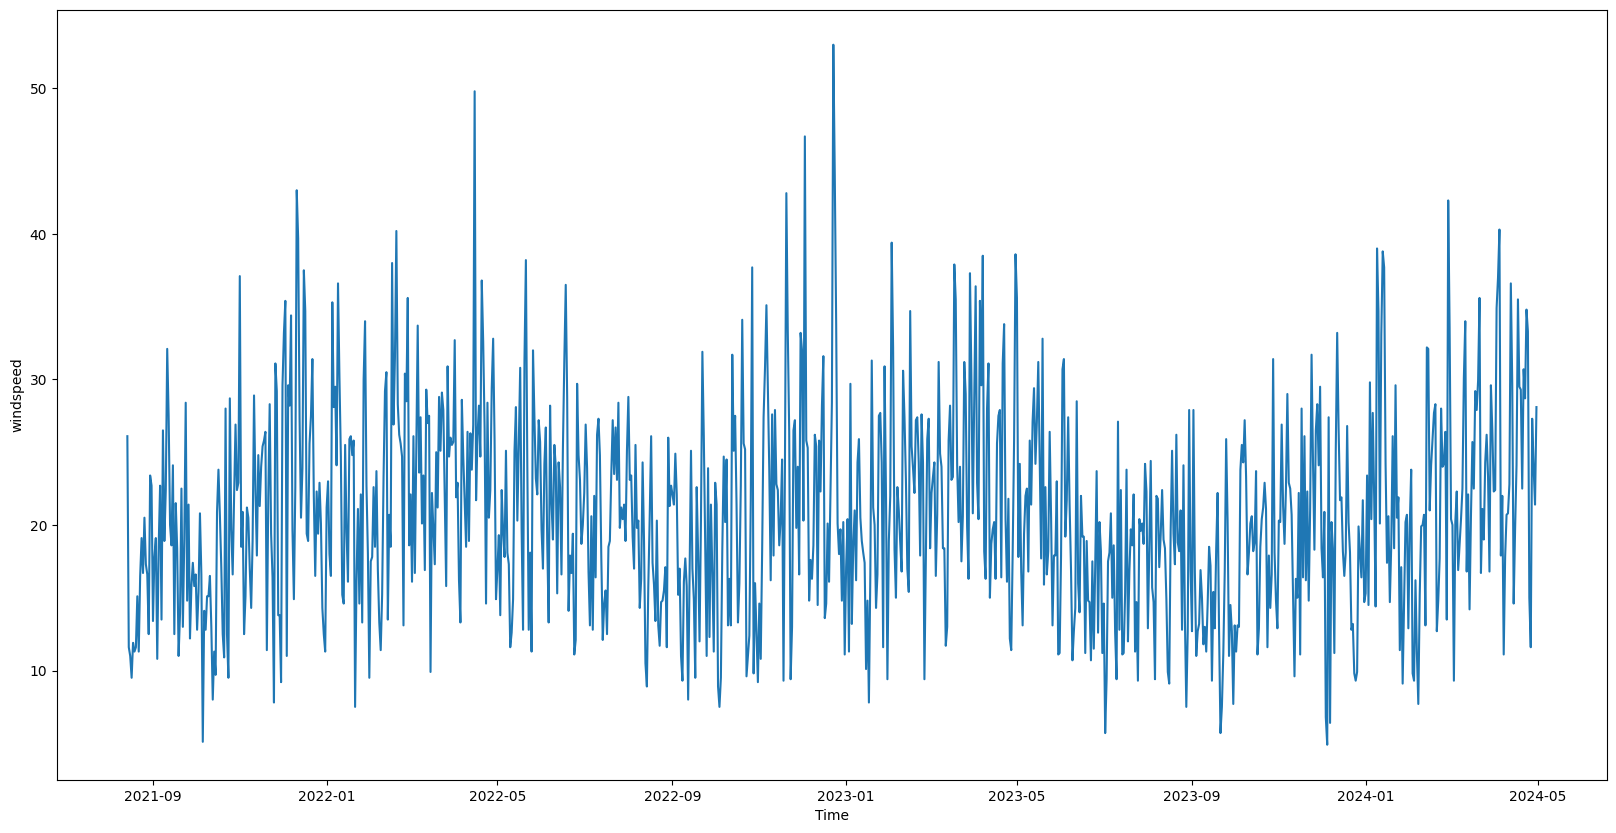

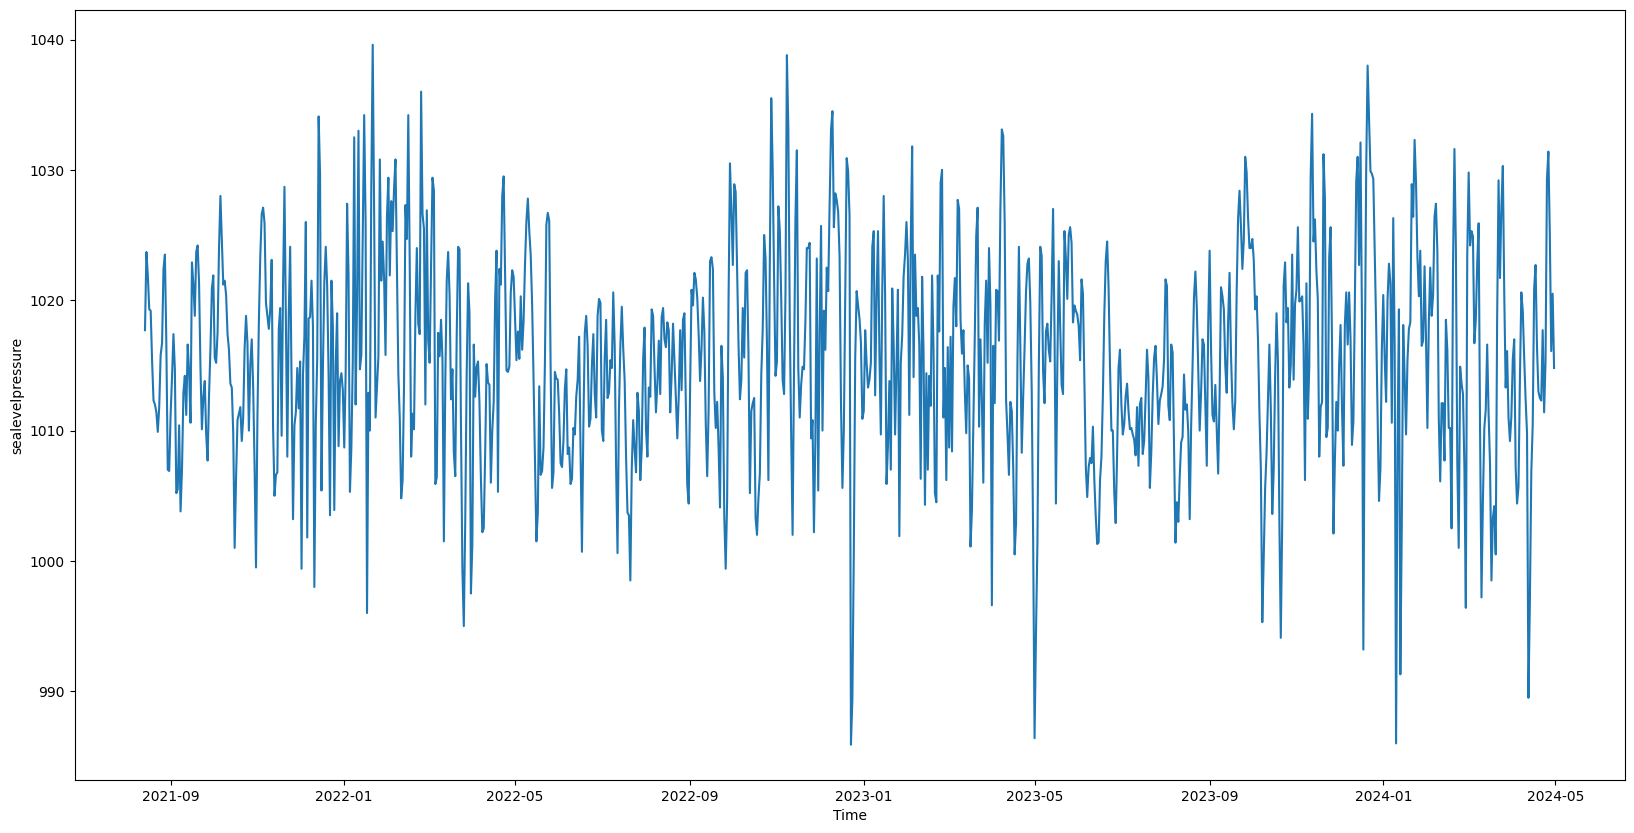

In [ ]:
for col in columns[1:]:
    plt.figure(figsize = (20,10))
    plt.plot(data_vis.index,data_vis[col])
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.show()

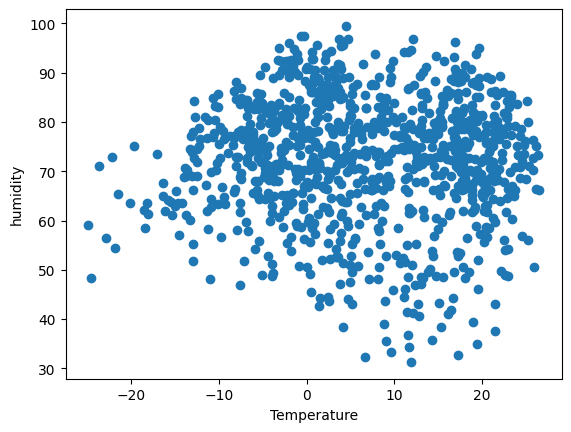

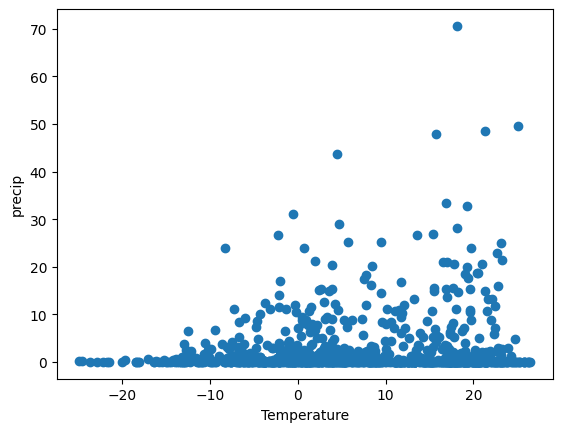

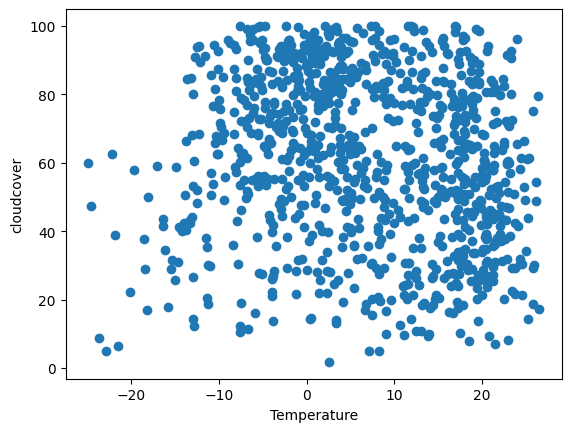

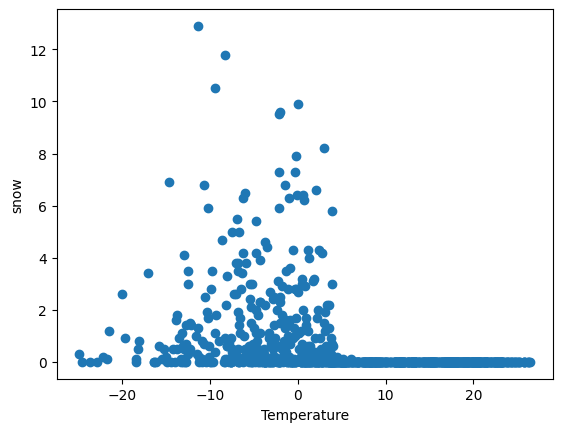

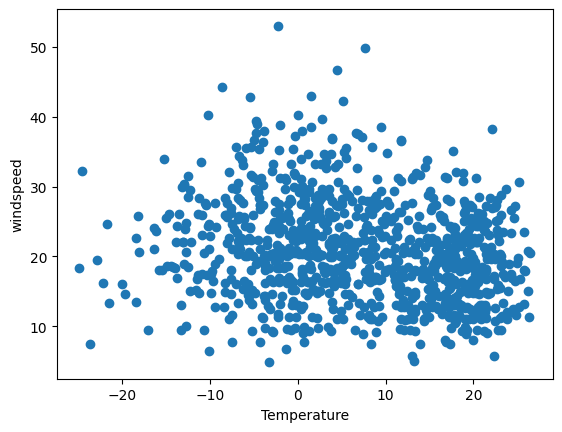

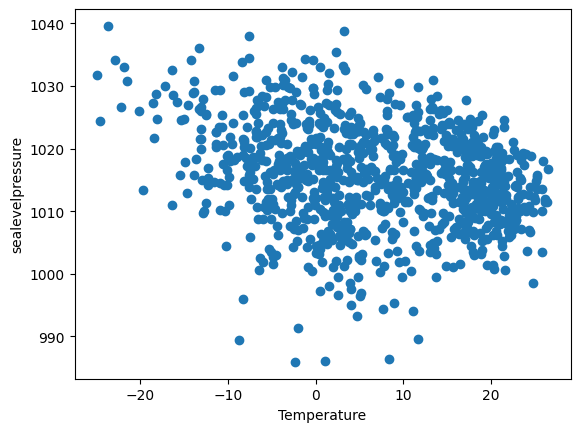

In [ ]:
for col in columns[2:]:

    plt.scatter(data_vis["temp"],data_vis[col])
    plt.xlabel("Temperature")
    plt.ylabel(col)
    plt.show()



In [ ]:
columns

['datetime',
 'temp',
 'humidity',
 'precip',
 'cloudcover',
 'snow',
 'windspeed',
 'sealevelpressure']

Analysis by month

In [ ]:
data_vis.groupby(data_vis.index.month).mean()

temp   humidity    precip  cloudcover      snow  windspeed  \
datetime                                                                    
1         -8.175269  76.847312  1.724172   66.975269  1.637634  21.250538   
2         -6.083529  70.616471  1.373694   64.324706  1.250588  22.707059   
3         -0.112903  68.301075  1.589591   65.722581  1.103226  23.322581   
4          6.972222  63.833333  3.171867   60.593333  0.363333  24.933333   
5         14.722581  57.941935  2.451597   46.987097  0.000000  21.433871   
6         18.625000  69.821667  2.918733   58.525000  0.000000  19.861667   
7         21.614516  70.933871  3.602048   51.337097  0.000000  18.664516   
8         20.341250  75.426250  3.753325   55.837500  0.000000  17.543750   
9         16.120000  76.567778  2.314511   54.754444  0.000000  17.000000   
10        10.773118  77.887097  2.570409   61.208602  0.018280  18.037634   
11         2.332222  74.012222  1.681333   62.884444  0.363333  21.681111   
12        -2.400000  79.301075  2.765860   74.829032  0.860215  22.087097   

          sealevelpressure  
datetime                    
1              1017.717204  
2              1017.257647  
3              1015.152688  
4              1014.756667  
5              1016.182258  
6              1011.790000  
7              1011.438710  
8              1013.928750  
9              1016.120000  
10             1014.847312  
11             1017.358889  
12             1017.631183

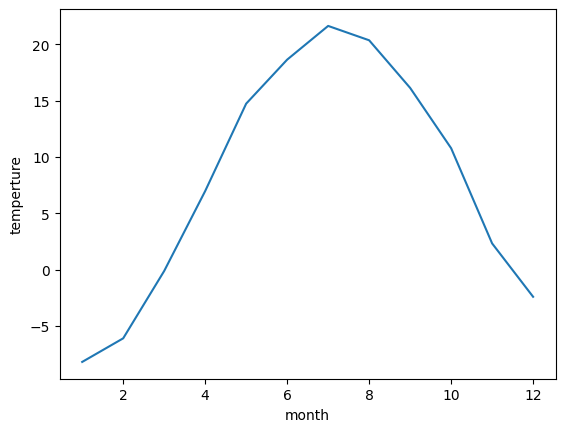

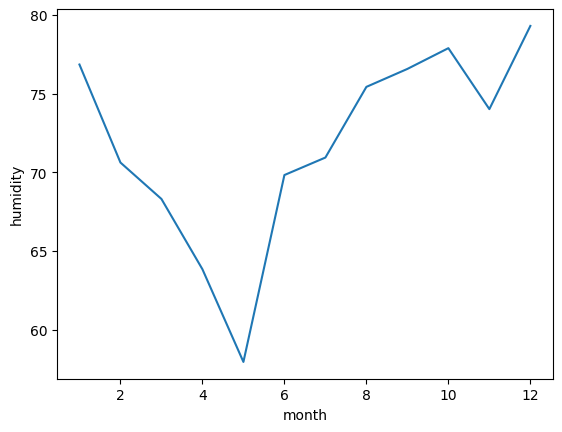

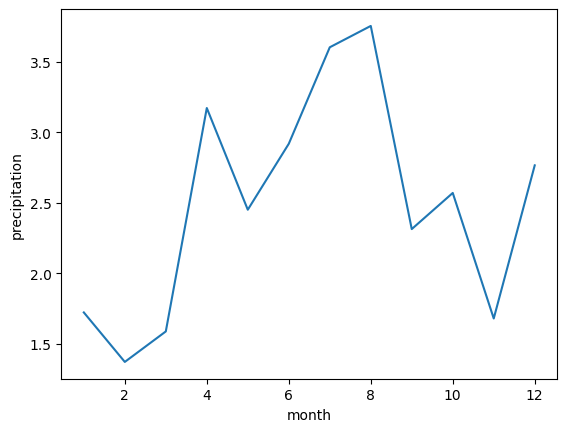

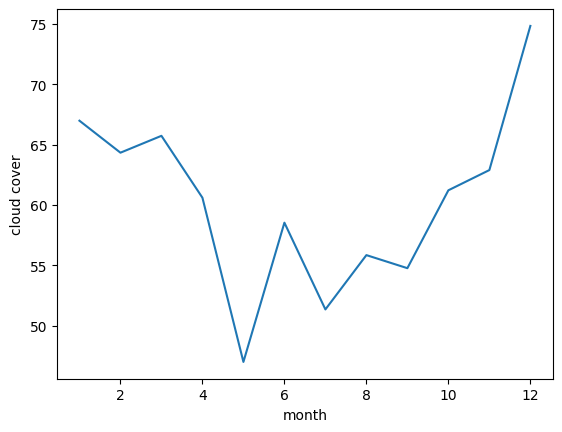

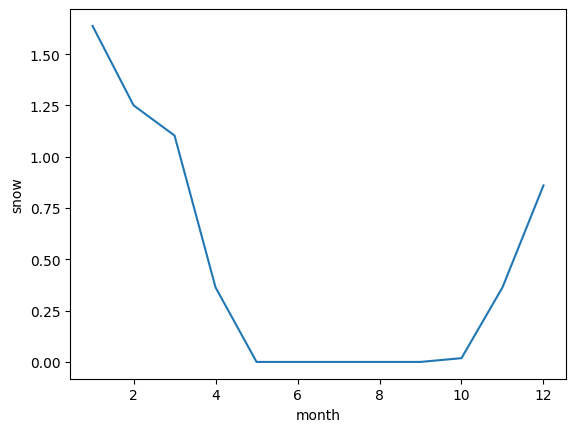

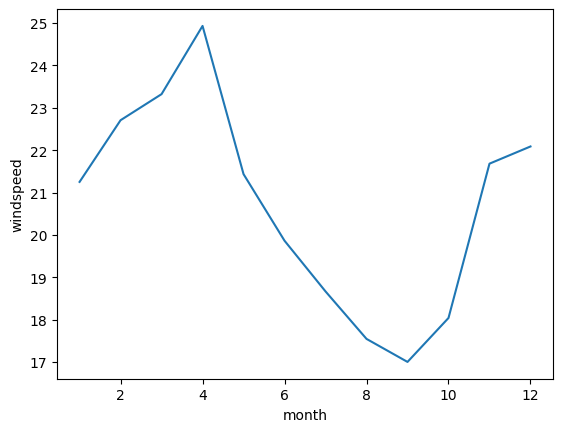

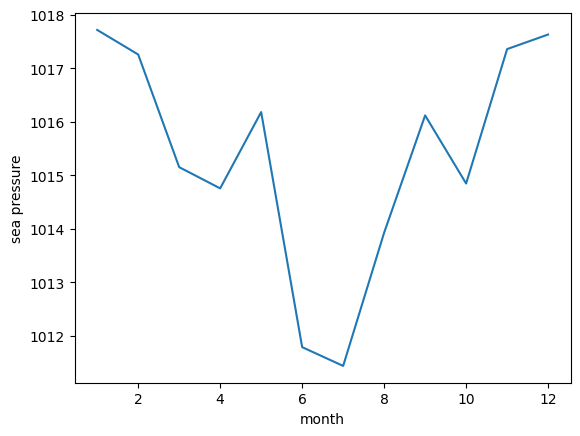

In [ ]:
data.groupby(data_vis.index.month).mean()["temp"].plot()
#plt.ylim(data["temp"].describe()["min"],data["temp"].describe()["max"])
plt.xlabel("month")
plt.ylabel("temperture")
plt.show()

data.groupby(data_vis.index.month).mean()["humidity"].plot()
#plt.ylim(data["humidity"].describe()["min"],data["humidity"].describe()["max"])
plt.xlabel("month")
plt.ylabel("humidity")
plt.show()

data.groupby(data_vis.index.month).mean()["precip"].plot()
#plt.ylim(data["precip"].describe()["min"],data["precip"].describe()["max"])
plt.xlabel("month")
plt.ylabel("precipitation")
plt.show()

data.groupby(data_vis.index.month).mean()["cloudcover"].plot()
#plt.ylim(data["cloudcover"].describe()["min"],data["cloudcover"].describe()["max"])
plt.xlabel("month")
plt.ylabel("cloud cover")
plt.show()

data.groupby(data_vis.index.month).mean()["snow"].plot()
#plt.ylim(data["snow"].describe()["min"],data["snow"].describe()["max"])
plt.xlabel("month")
plt.ylabel("snow")
plt.show()

data.groupby(data_vis.index.month).mean()["windspeed"].plot()
#plt.ylim(data["windspeed"].describe()["min"],data["windspeed"].describe()["max"])
plt.xlabel("month")
plt.ylabel("windspeed")
plt.show()

data.groupby(data_vis.index.month).mean()["sealevelpressure"].plot()
#plt.ylim(data["sealevelpressure"].describe()["min"],data["sealevelpressure"].describe()["max"])
plt.xlabel("month")
plt.ylabel("sea pressure")
plt.show()

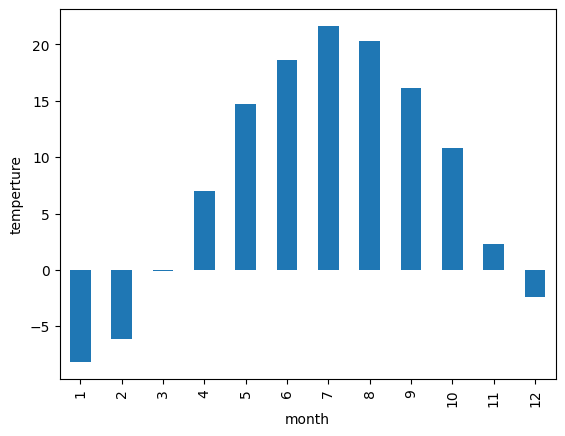

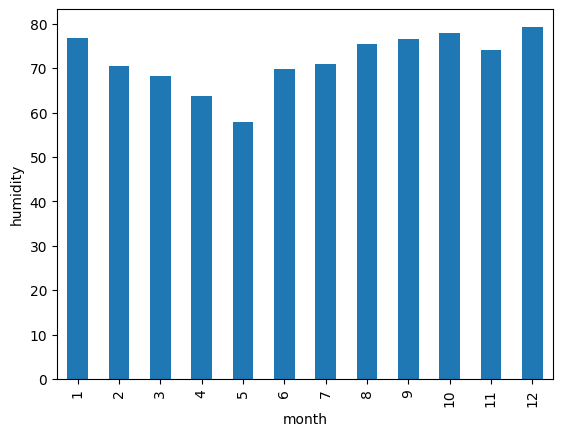

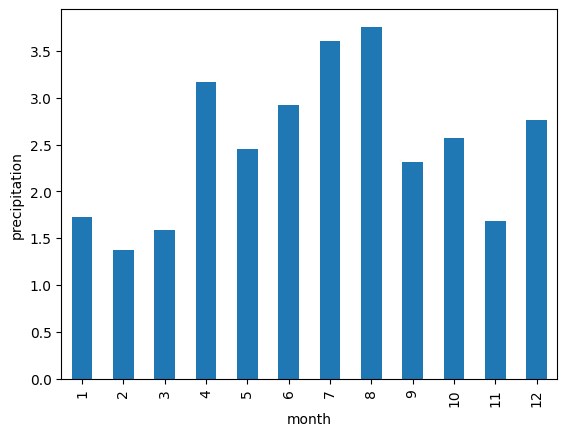

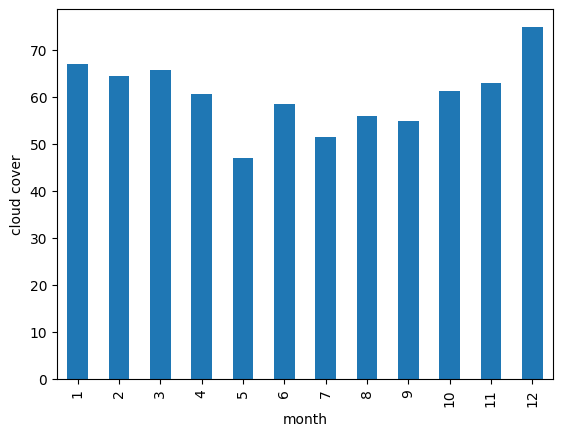

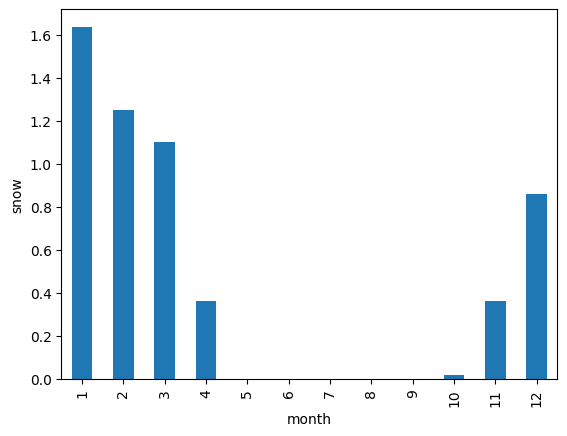

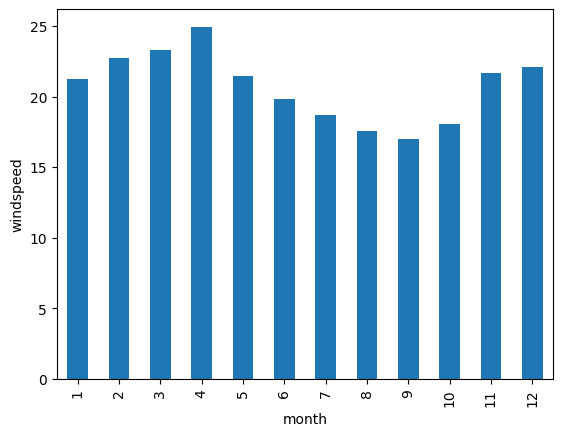

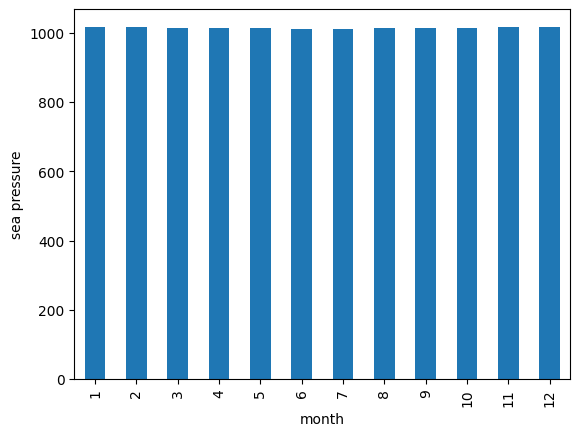

In [ ]:
data_vis.groupby(data_vis.index.month).mean()["temp"].plot(kind = "bar")

plt.xlabel("month")
plt.ylabel("temperture")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["humidity"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("humidity")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["precip"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("precipitation")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["cloudcover"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("cloud cover")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["snow"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("snow")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["windspeed"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("windspeed")
plt.show()

data_vis.groupby(data_vis.index.month).mean()["sealevelpressure"].plot(kind = "bar")
plt.xlabel("month")
plt.ylabel("sea pressure")
plt.show()

Analysis quarterly

In [ ]:
data_vis.groupby(data_vis.index.quarter).mean()

temp   humidity    precip  cloudcover      snow  windspeed  \
datetime                                                                    
1         -4.752399  71.960148  1.568059   65.714022  1.332841  22.418450   
2         12.536792  63.805189  2.889580   56.028774  0.154245  22.474528   
3         19.043966  74.668534  3.154737   54.214655  0.000000  17.632328   
4          3.581884  77.100000  2.346351   66.344565  0.414493  20.590217   

          sealevelpressure  
datetime                    
1              1016.692989  
2              1014.333962  
3              1014.113362  
4              1016.604348

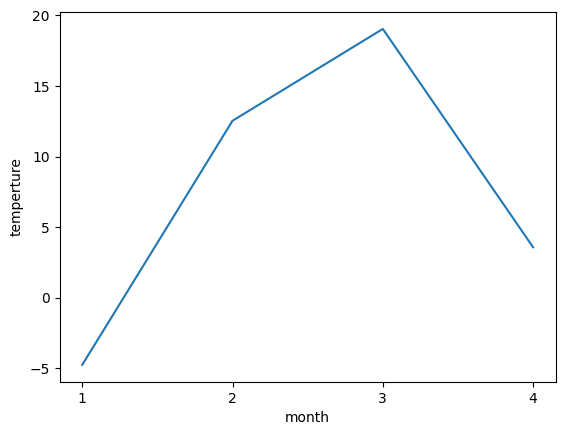

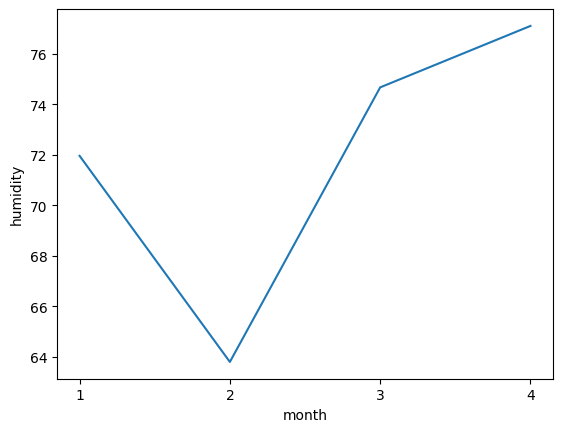

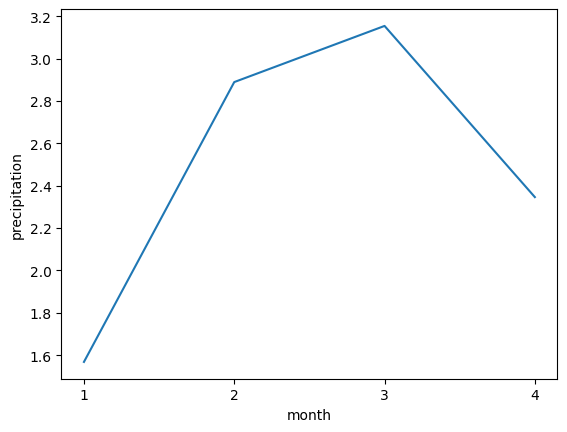

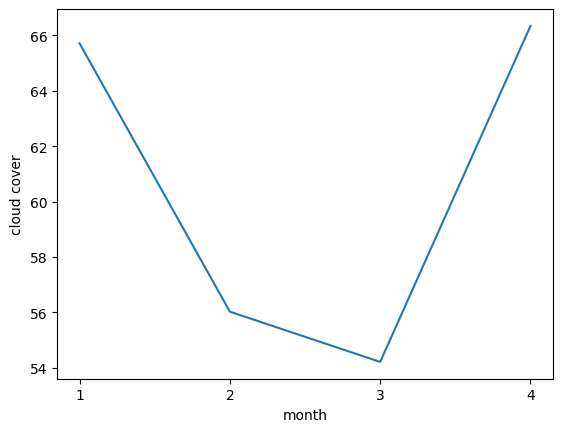

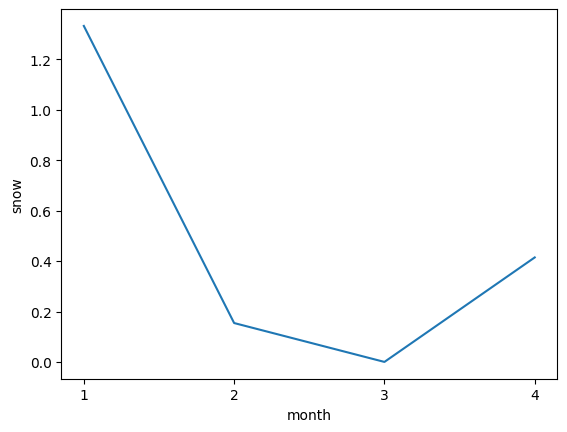

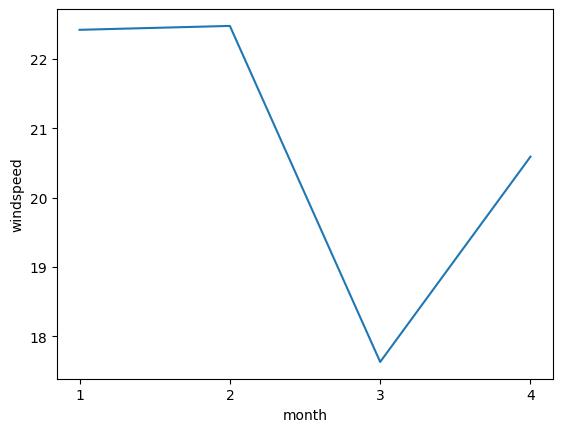

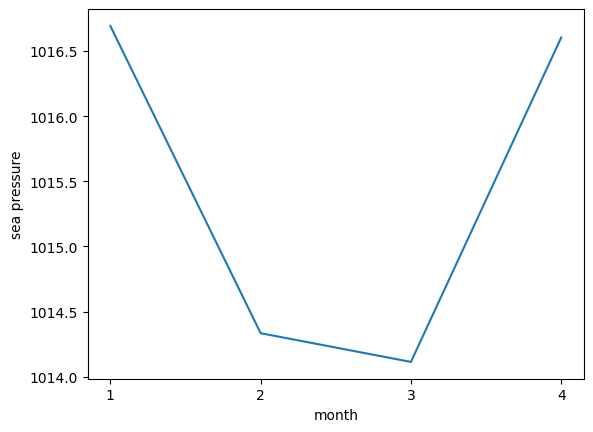

In [ ]:

data.groupby(data_vis.index.quarter).mean()["temp"].plot()
#plt.ylim(data["temp"].describe()["min"],data["temp"].describe()["max"])
plt.xlabel("month")
plt.ylabel("temperture")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["humidity"].plot()
#plt.ylim(data["humidity"].describe()["min"],data["humidity"].describe()["max"])
plt.xlabel("month")
plt.ylabel("humidity")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["precip"].plot()
#plt.ylim(data["precip"].describe()["min"],data["precip"].describe()["max"])
plt.xlabel("month")
plt.ylabel("precipitation")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["cloudcover"].plot()
#plt.ylim(data["cloudcover"].describe()["min"],data["cloudcover"].describe()["max"])
plt.xlabel("month")
plt.ylabel("cloud cover")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["snow"].plot()
#plt.ylim(data["snow"].describe()["min"],data["snow"].describe()["max"])
plt.xlabel("month")
plt.ylabel("snow")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["windspeed"].plot()
#plt.ylim(data["windspeed"].describe()["min"],data["windspeed"].describe()["max"])
plt.xlabel("month")
plt.ylabel("windspeed")
plt.xticks([1,2,3,4])
plt.show()

data.groupby(data_vis.index.quarter).mean()["sealevelpressure"].plot()
#plt.ylim(data["sealevelpressure"].describe()["min"],data["sealevelpressure"].describe()["max"])
plt.xlabel("month")
plt.ylabel("sea pressure")
plt.xticks([1,2,3,4])
plt.show()

Correlation analysis

In [ ]:
corr_matrix = data.corr()
corr_matrix

datetime      temp  humidity    precip  cloudcover  \
datetime          1.000000 -0.039758 -0.015814 -0.006684    0.022089   
temp             -0.039758  1.000000 -0.014288  0.114348   -0.146237   
humidity         -0.015814 -0.014288  1.000000  0.394415    0.604061   
precip           -0.006684  0.114348  0.394415  1.000000    0.351465   
cloudcover        0.022089 -0.146237  0.604061  0.351465    1.000000   
snow              0.034770 -0.359175  0.191815  0.161088    0.232933   
windspeed        -0.012196 -0.200443 -0.155557  0.133326    0.159254   
sealevelpressure -0.009027 -0.274027 -0.349083 -0.357010   -0.420222   

                      snow  windspeed  sealevelpressure  
datetime          0.034770  -0.012196         -0.009027  
temp             -0.359175  -0.200443         -0.274027  
humidity          0.191815  -0.155557         -0.349083  
precip            0.161088   0.133326         -0.357010  
cloudcover        0.232933   0.159254         -0.420222  
snow              1.000000   0.178169         -0.107245  
windspeed         0.178169   1.000000         -0.293876  
sealevelpressure -0.107245  -0.293876          1.000000

<Axes: >

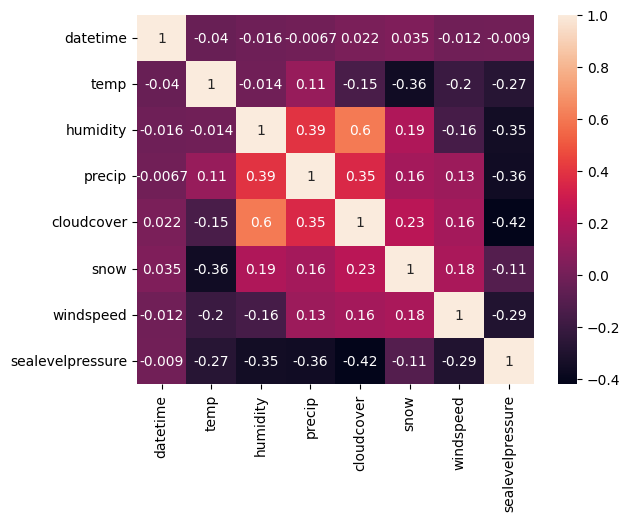

In [ ]:
sns.heatmap(corr_matrix,annot = True)

# Data normalization and reshaping

In [ ]:
final_data = data.drop('datetime',axis = 1)

In [ ]:
# 80% train data, 20% validation data
size = int(0.8 * final_data.shape[0])
train_data = final_data[:size]
val_data = final_data[size:]

In [ ]:
train_data.shape, val_data.shape

((792, 7), (199, 7))

In [ ]:
train_data

temp  humidity  precip  cloudcover  snow  windspeed  sealevelpressure
0    20.8      58.5   0.209        44.1   0.0       26.1            1017.7
1    17.8      61.9   0.000        18.4   0.0       11.6            1023.7
2    19.1      62.1   0.000        45.6   0.0       11.0            1021.9
3    19.3      85.1   0.005        84.2   0.0        9.5            1019.3
4    24.0      83.7   0.000        96.1   0.0       11.9            1019.2
..    ...       ...     ...         ...   ...        ...               ...
787   8.7      82.2   0.452        83.3   0.0       16.6            1005.6
788  10.0      83.8   2.751        77.5   0.0       18.1            1008.3
789   8.8      78.1   0.083        55.0   0.0       20.1            1012.6
790  10.0      77.4   0.000        42.4   0.0       20.6            1016.6
791  10.4      74.6   0.000        46.1   0.0       18.2            1011.6

[792 rows x 7 columns]

In [ ]:
val_data

temp  humidity  precip  cloudcover  snow  windspeed  sealevelpressure
792   9.3      82.4   0.451        73.0   0.0       18.8            1003.6
793  11.2      78.6   0.000        59.0   0.0       23.7            1006.9
794   8.5      81.1   0.000        37.8   0.0       11.1            1014.0
795   9.2      79.9   0.000        59.3   0.0       12.9            1019.0
796  12.5      67.9   0.000        71.5   0.0       18.5            1015.3
..    ...       ...     ...         ...   ...        ...               ...
986   7.1      48.1   0.023         5.1   0.0       11.6            1031.4
987  10.4      58.5   1.566        72.6   0.0       27.3            1025.1
988  14.3      74.9   5.170        92.5   0.0       24.0            1016.1
989   8.8      62.9   1.413        92.7   0.0       21.4            1020.5
990   7.3      87.6   9.116       100.0   0.0       28.1            1014.8

[199 rows x 7 columns]

In [ ]:
scale = MinMaxScaler()
scaled_train = scale.fit_transform(train_data)
scaled_train

array([[0.88910506, 0.39882698, 0.00295963, ..., 0.        , 0.43841336,
        0.59217877],
       [0.8307393 , 0.44868035, 0.        , ..., 0.        , 0.13569937,
        0.70391061],
       [0.85603113, 0.4516129 , 0.        , ..., 0.        , 0.12317328,
        0.67039106],
       ...,
       [0.65564202, 0.68621701, 0.00117535, ..., 0.        , 0.3131524 ,
        0.4972067 ],
       [0.67898833, 0.67595308, 0.        , ..., 0.        , 0.32359081,
        0.5716946 ],
       [0.68677043, 0.63489736, 0.        , ..., 0.        , 0.27348643,
        0.47858473]])

In [ ]:
x_train = scaled_train
y_train = scaled_train[:,0]

In [ ]:
x_train.shape, y_train.shape

((792, 7), (792,))

test

In [ ]:
scaled_val = scale.transform(val_data)
scaled_val

array([[0.66536965, 0.74926686, 0.00638656, ..., 0.        , 0.28601253,
        0.32960894],
       [0.70233463, 0.69354839, 0.        , ..., 0.        , 0.38830898,
        0.39106145],
       [0.64980545, 0.73020528, 0.        , ..., 0.        , 0.12526096,
        0.52327747],
       ...,
       [0.76264591, 0.63929619, 0.07321183, ..., 0.        , 0.39457203,
        0.56238361],
       [0.65564202, 0.46334311, 0.02000935, ..., 0.        , 0.34029228,
        0.6443203 ],
       [0.62645914, 0.8255132 , 0.12909073, ..., 0.        , 0.48016701,
        0.53817505]])

In [ ]:
scaled_val.shape

(199, 7)

In [ ]:
x_test = scaled_val
y_test = scaled_val[:,0]

In [ ]:
x_test.shape, y_test.shape

((199, 7), (199,))

Addition of timestamp

In [ ]:
timestamp = 120
train_input, train_output = [],[]

for i in range(timestamp,scaled_train.shape[0]):
  train_input.append(x_train[i-timestamp:i])
  train_output.append(x_train[i])

In [ ]:
train_input,train_output = np.array(train_input),np.array(train_output)
train_input.shape, train_output.shape

((672, 120, 7), (672, 7))

In [ ]:
train_output

array([[0.53696498, 0.39442815, 0.        , ..., 0.        , 0.7223382 ,
        0.45810056],
       [0.57003891, 0.47507331, 0.        , ..., 0.        , 0.46346555,
        0.55121043],
       [0.47859922, 0.52346041, 0.        , ..., 0.        , 0.32150313,
        0.89757914],
       ...,
       [0.65564202, 0.68621701, 0.00117535, ..., 0.        , 0.3131524 ,
        0.4972067 ],
       [0.67898833, 0.67595308, 0.        , ..., 0.        , 0.32359081,
        0.5716946 ],
       [0.68677043, 0.63489736, 0.        , ..., 0.        , 0.27348643,
        0.47858473]])

In [ ]:
test_input, test_output = [],[]

for i in range(timestamp,scaled_val.shape[0]):
  test_input.append(x_test[i-timestamp:i])
  test_output.append(x_test[i])

test_input,test_output = np.array(test_input),np.array(test_output)
test_input.shape, test_output.shape


((79, 120, 7), (79, 7))

# Model building

In [ ]:
train_input.shape[1],train_input.shape[2]

(120, 7)

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(units = 100, return_sequences = True,input_shape = (train_input.shape[1],train_input.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 75,return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units = 75,return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(units = 50))
model.add(Dropout(0.1))

In [ ]:
model.add(Dense(units = 7))

In [ ]:
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 120, 100)          43200     
                                                                 
 dropout_4 (Dropout)         (None, 120, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 120, 75)           52800     
                                                                 
 dropout_5 (Dropout)         (None, 120, 75)           0         
                                                                 
 lstm_6 (LSTM)               (None, 120, 75)           45300     
                                                                 
 dropout_6 (Dropout)         (None, 120, 75)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [ ]:
model.fit(train_input,train_output,batch_size = 64,epochs = 200)

Epoch 1/200
11/11 [==============================] - 18s 685ms/step - loss: 0.0757
Epoch 2/200
11/11 [==============================] - 6s 503ms/step - loss: 0.0355
Epoch 3/200
11/11 [==============================] - 6s 572ms/step - loss: 0.0306
Epoch 4/200
11/11 [==============================] - 7s 579ms/step - loss: 0.0296
Epoch 5/200
11/11 [==============================] - 6s 519ms/step - loss: 0.0287
Epoch 6/200
11/11 [==============================] - 8s 680ms/step - loss: 0.0278
Epoch 7/200
11/11 [==============================] - 6s 515ms/step - loss: 0.0277
Epoch 8/200
11/11 [==============================] - 8s 704ms/step - loss: 0.0274
Epoch 9/200
11/11 [==============================] - 6s 516ms/step - loss: 0.0273
Epoch 10/200
11/11 [==============================] - 8s 702ms/step - loss: 0.0278
Epoch 11/200
11/11 [==============================] - 6s 520ms/step - loss: 0.0272
Epoch 12/200
11/11 [==============================] - 8s 711ms/step - loss: 0.0274
Epoch 13/200

# Model Evaluation

### train data

In [ ]:
pred_train = model.predict(train_input)
#unscaled_predicted_train = scale.inverse_transform(np.repeat(pred_train,7,axis = -1))[:,0]
#unscaled_train_output = scale.inverse_transform(np.repeat(train_output.reshape(-1,1),7,axis = -1))[:,0]

unscaled_predicted_train = scale.inverse_transform(pred_train)
unscaled_train_output = scale.inverse_transform(train_output)

21/21 [==============================] - 3s 126ms/step


Text(0.5, 1.0, 'temp - train data')

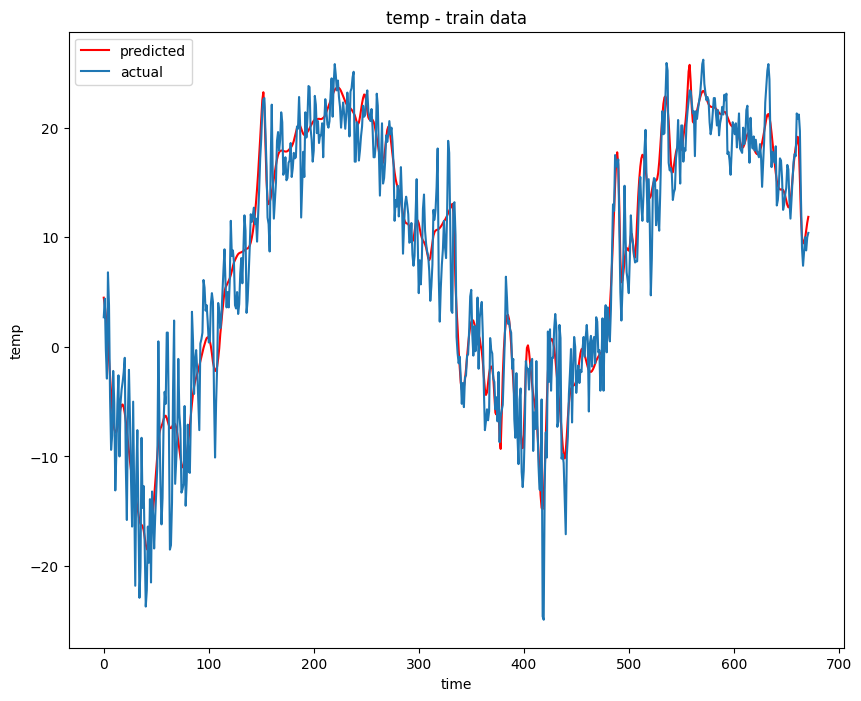

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,0],c = 'r')
plt.plot(unscaled_train_output[:,0])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('temp - train data')

Text(0.5, 1.0, 'humidity - train data')

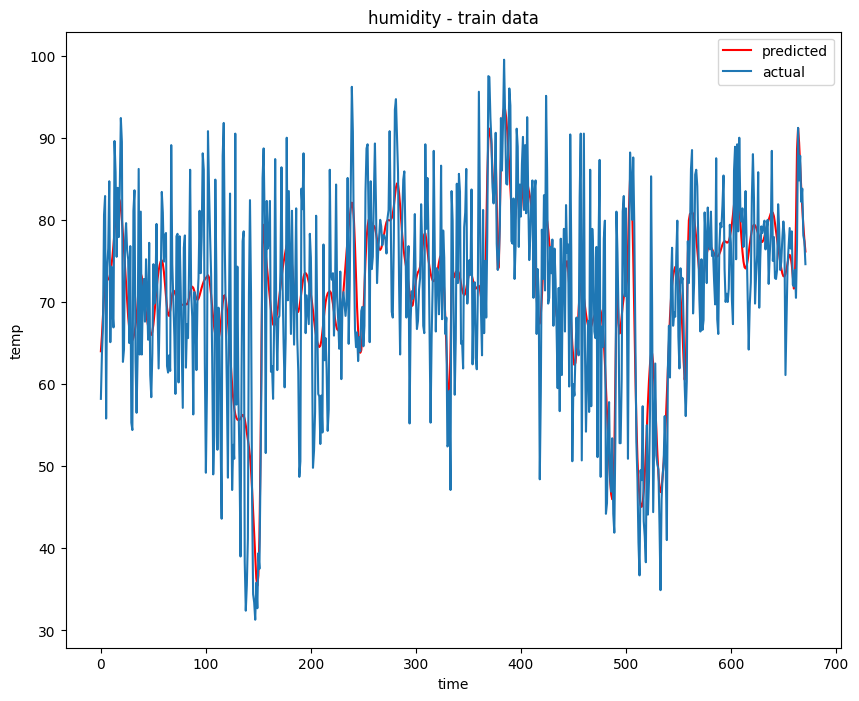

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,1],c = 'r')
plt.plot(unscaled_train_output[:,1])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('humidity - train data')

Text(0.5, 1.0, 'precip - train data')

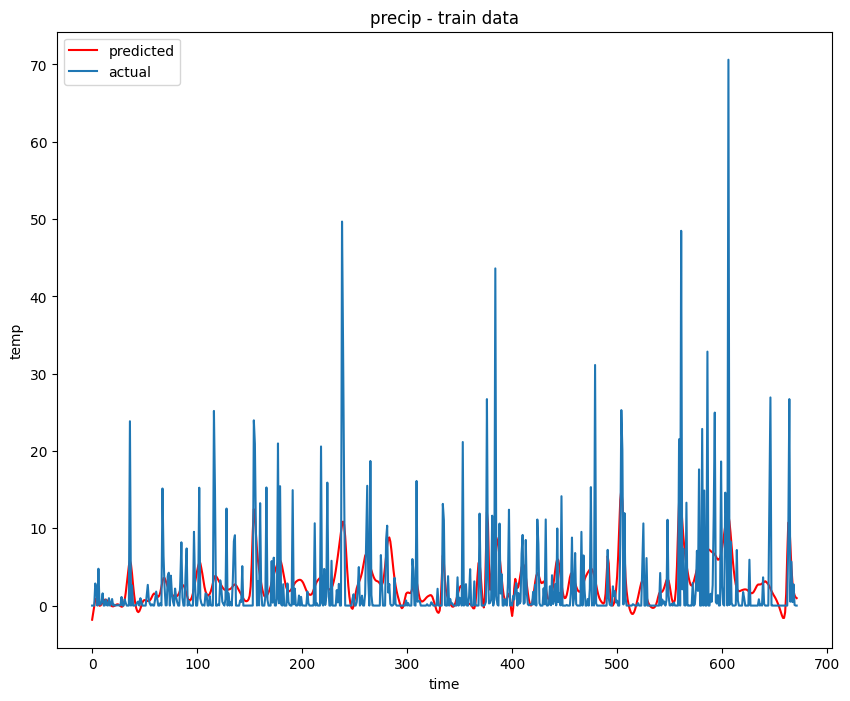

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,2],c = 'r')
plt.plot(unscaled_train_output[:,2])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('precip - train data')

Text(0.5, 1.0, 'cloudcover - train data')

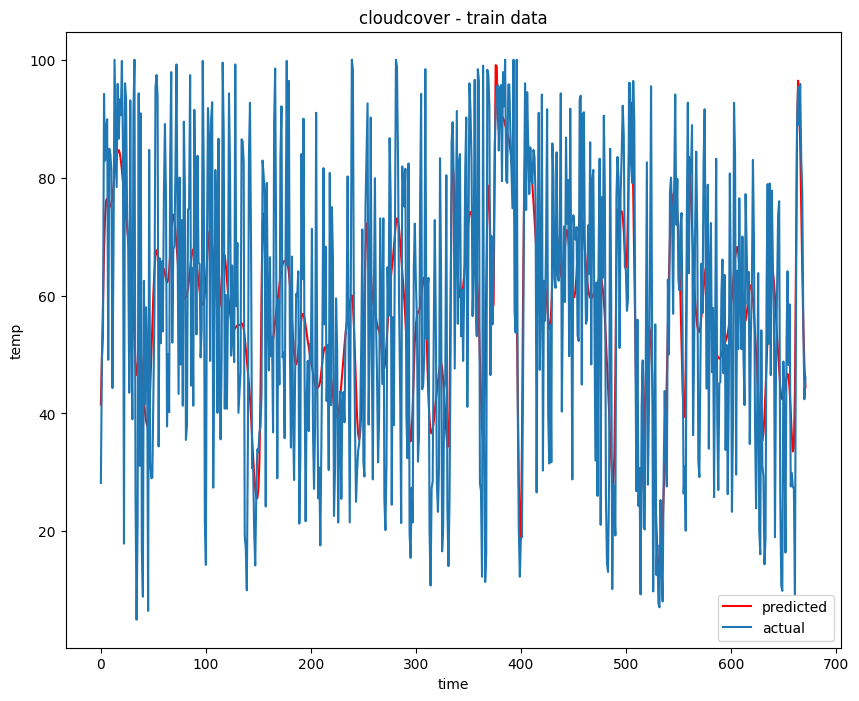

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,3],c = 'r')
plt.plot(unscaled_train_output[:,3])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('cloudcover - train data')

Text(0.5, 1.0, ' windspeed - train data')

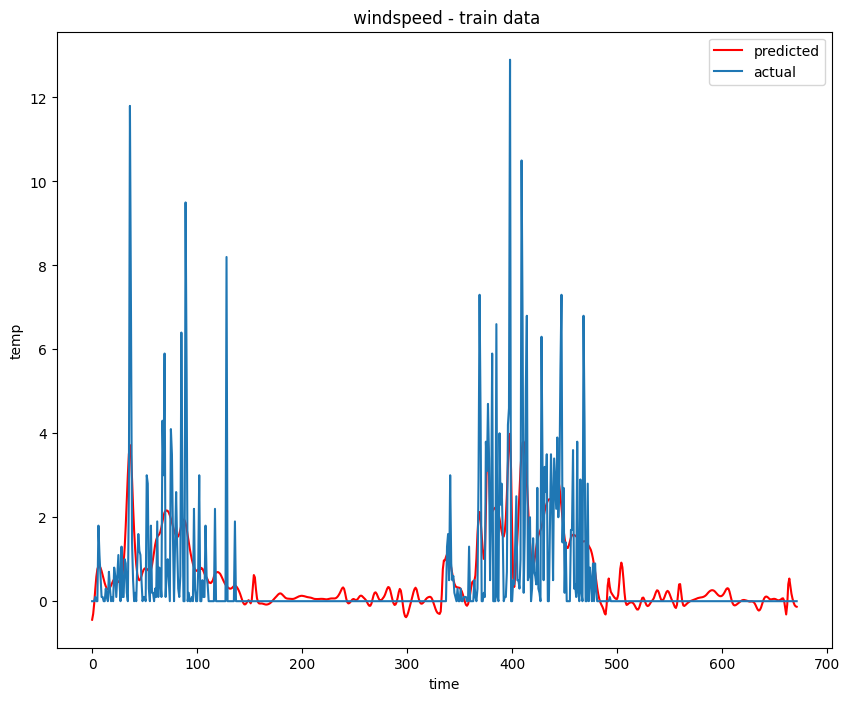

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,4],c = 'r')
plt.plot(unscaled_train_output[:,4])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title(' windspeed - train data')

Text(0.5, 1.0, 'sealevelpressure - train data')

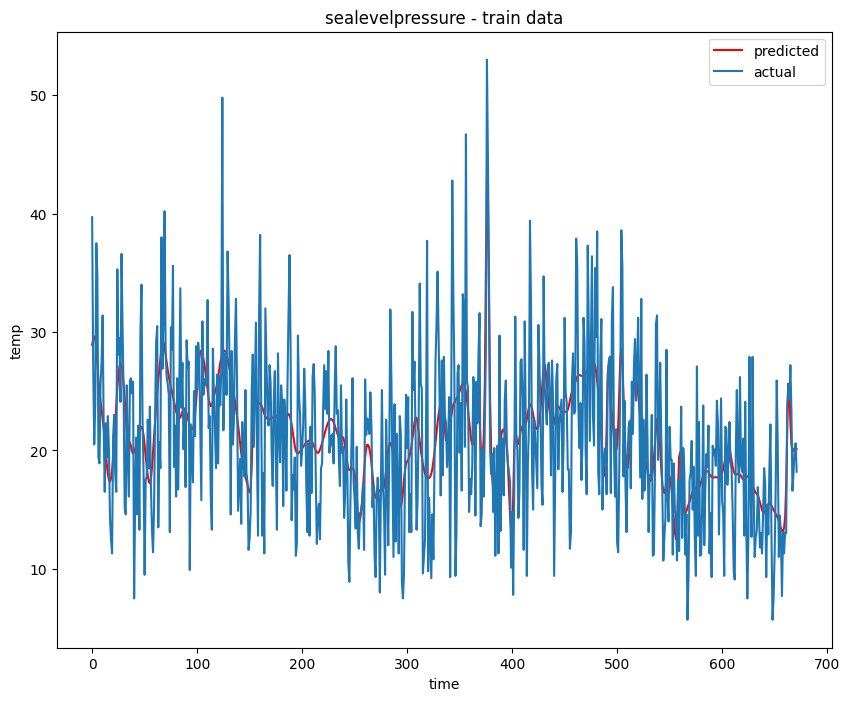

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(unscaled_predicted_train[:,5],c = 'r')
plt.plot(unscaled_train_output[:,5])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('sealevelpressure - train data')

In [ ]:
#plt.plot(predicted_vals,c = 'r')
#plt.plot(test_output)

### validation data

In [ ]:
predicted_vals = model.predict(test_input)

3/3 [==============================] - 2s 80ms/step


In [ ]:
test_output.shape, predicted_vals.shape

((79, 7), (79, 7))

In [ ]:
#unscaled_predicted_vals = scale.inverse_transform(np.repeat(predicted_vals,7,axis = -1))[:,0]
#unscaled_test_output = scale.inverse_transform(np.repeat(test_output.reshape(-1,1),7,axis = -1))[:,0]

unscaled_predicted_vals = scale.inverse_transform(predicted_vals)
unscaled_test_output = scale.inverse_transform(test_output)

Text(0.5, 1.0, 'temp - validation data')

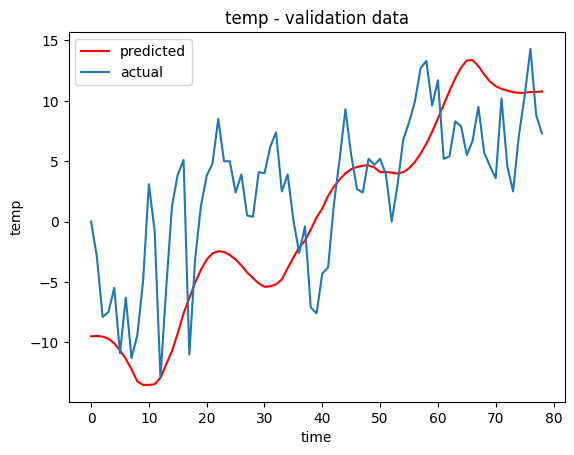

In [ ]:
plt.plot(unscaled_predicted_vals[:,0],c = 'r')
plt.plot(unscaled_test_output[:,0])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('temp - validation data')

Text(0.5, 1.0, 'humidity - validation data')

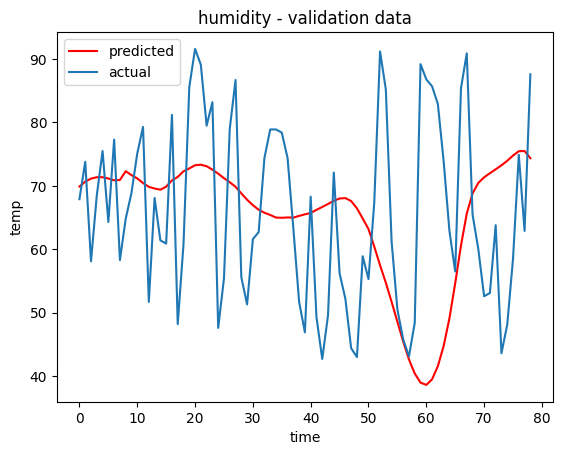

In [ ]:
plt.plot(unscaled_predicted_vals[:,1],c = 'r')
plt.plot(unscaled_test_output[:,1])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('humidity - validation data')

Text(0.5, 1.0, 'precip - validation data')

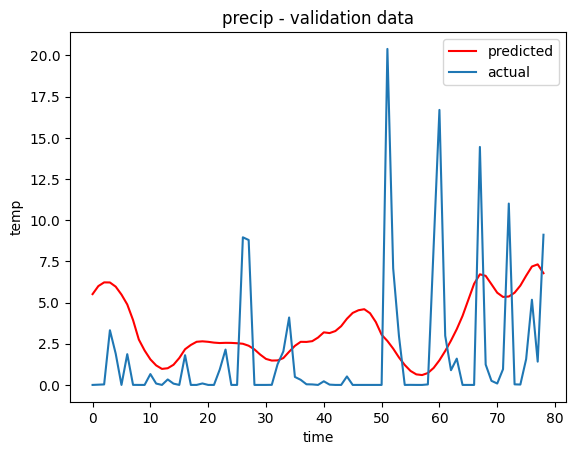

In [ ]:
plt.plot(unscaled_predicted_vals[:,2],c = 'r')
plt.plot(unscaled_test_output[:,2])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('precip - validation data')

Text(0.5, 1.0, 'cloudcover - validation data')

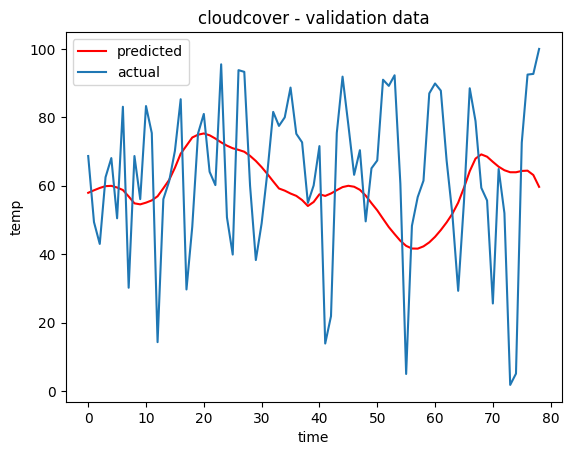

In [ ]:
plt.plot(unscaled_predicted_vals[:,3],c = 'r')
plt.plot(unscaled_test_output[:,3])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('cloudcover - validation data')

Text(0.5, 1.0, 'windspeed - validation data')

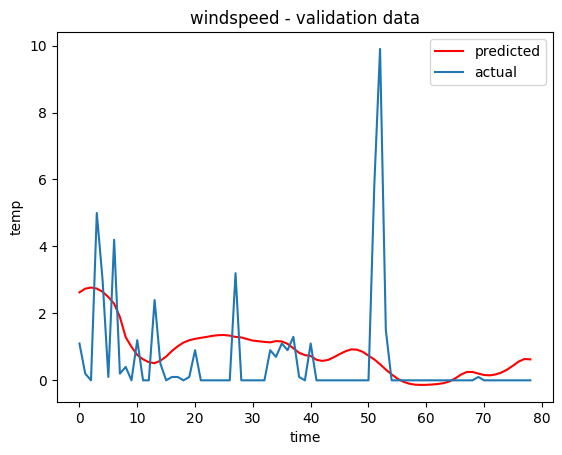

In [ ]:
plt.plot(unscaled_predicted_vals[:,4],c = 'r')
plt.plot(unscaled_test_output[:,4])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('windspeed - validation data')

Text(0.5, 1.0, 'sealevelpressure - validation data')

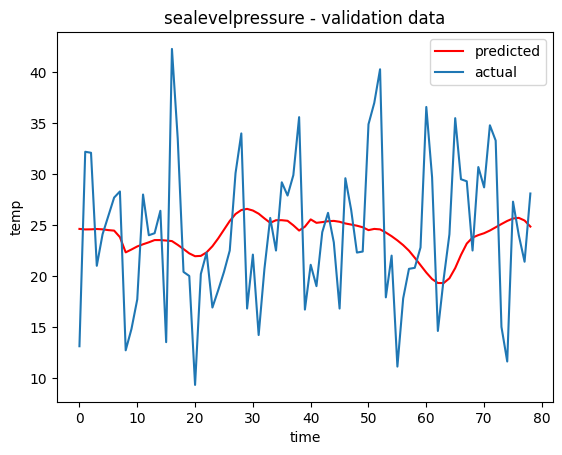

In [ ]:
plt.plot(unscaled_predicted_vals[:,5],c = 'r')
plt.plot(unscaled_test_output[:,5])
plt.legend(['predicted','actual'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('sealevelpressure - validation data')

### Complete figure

Text(0.5, 1.0, 'temp - Overall Data')

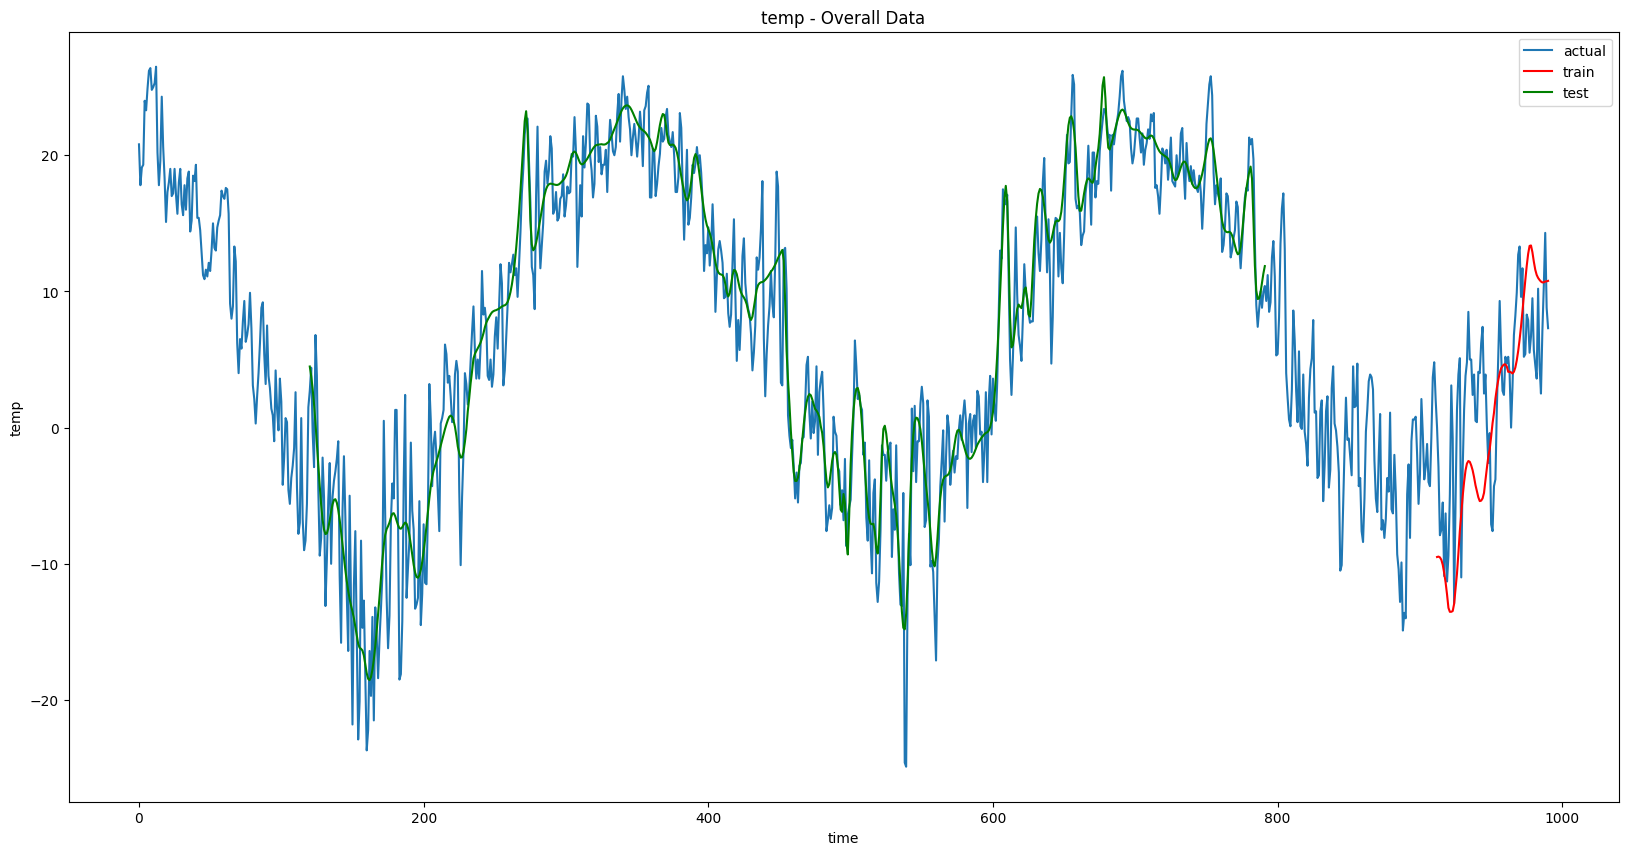

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["temp"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,0],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,0],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('temp - Overall Data')

Text(0.5, 1.0, 'humidity - Overall Data')

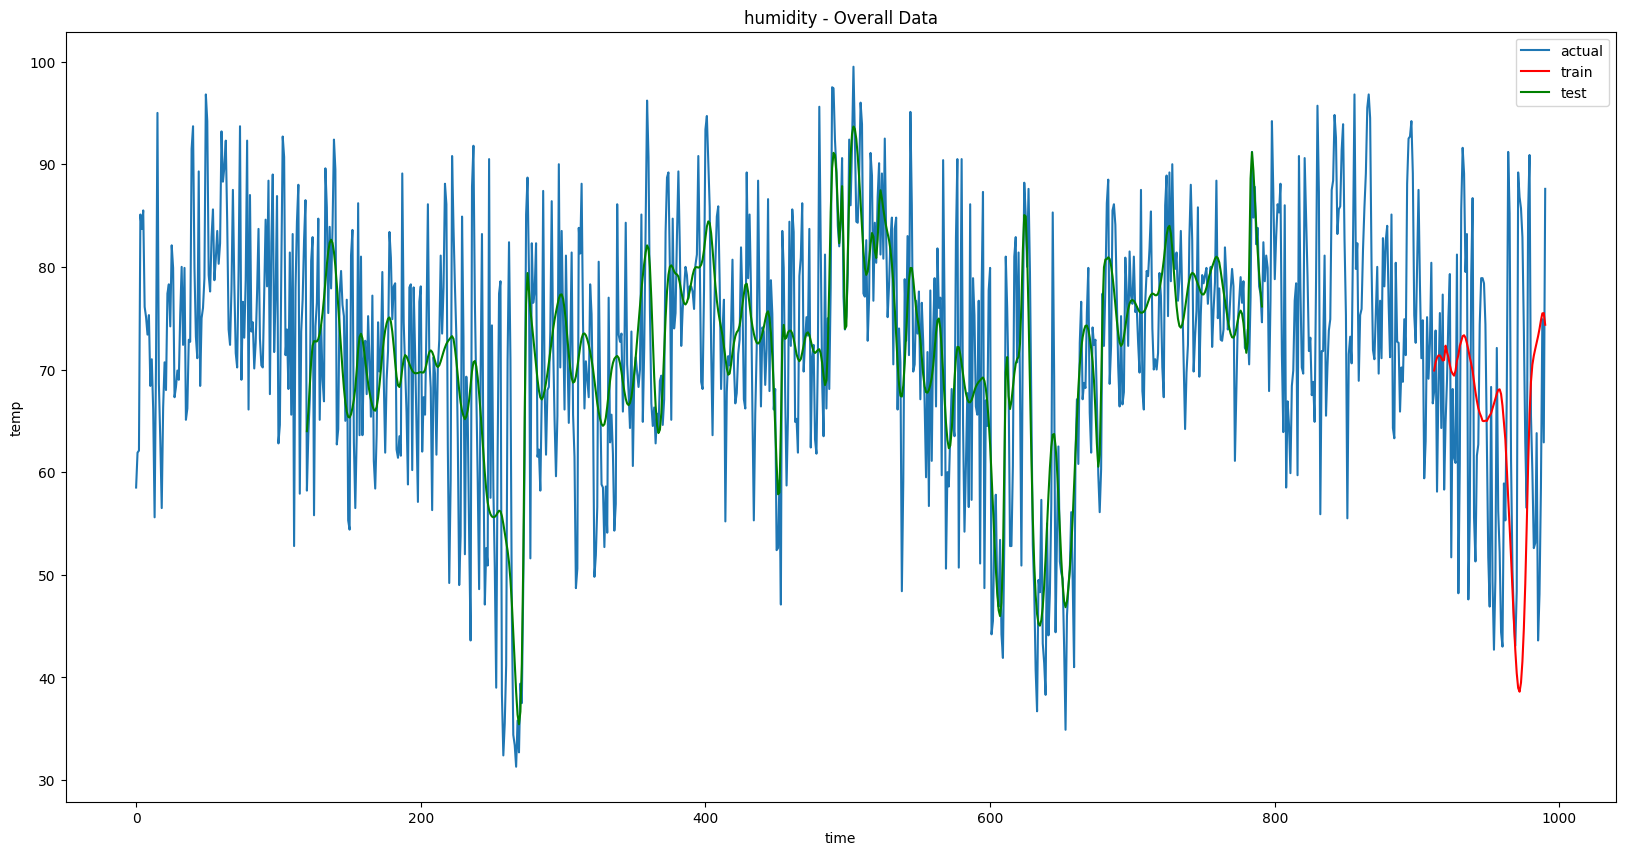

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["humidity"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,1],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,1],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('humidity - Overall Data')

Text(0.5, 1.0, 'precip - Overall Data')

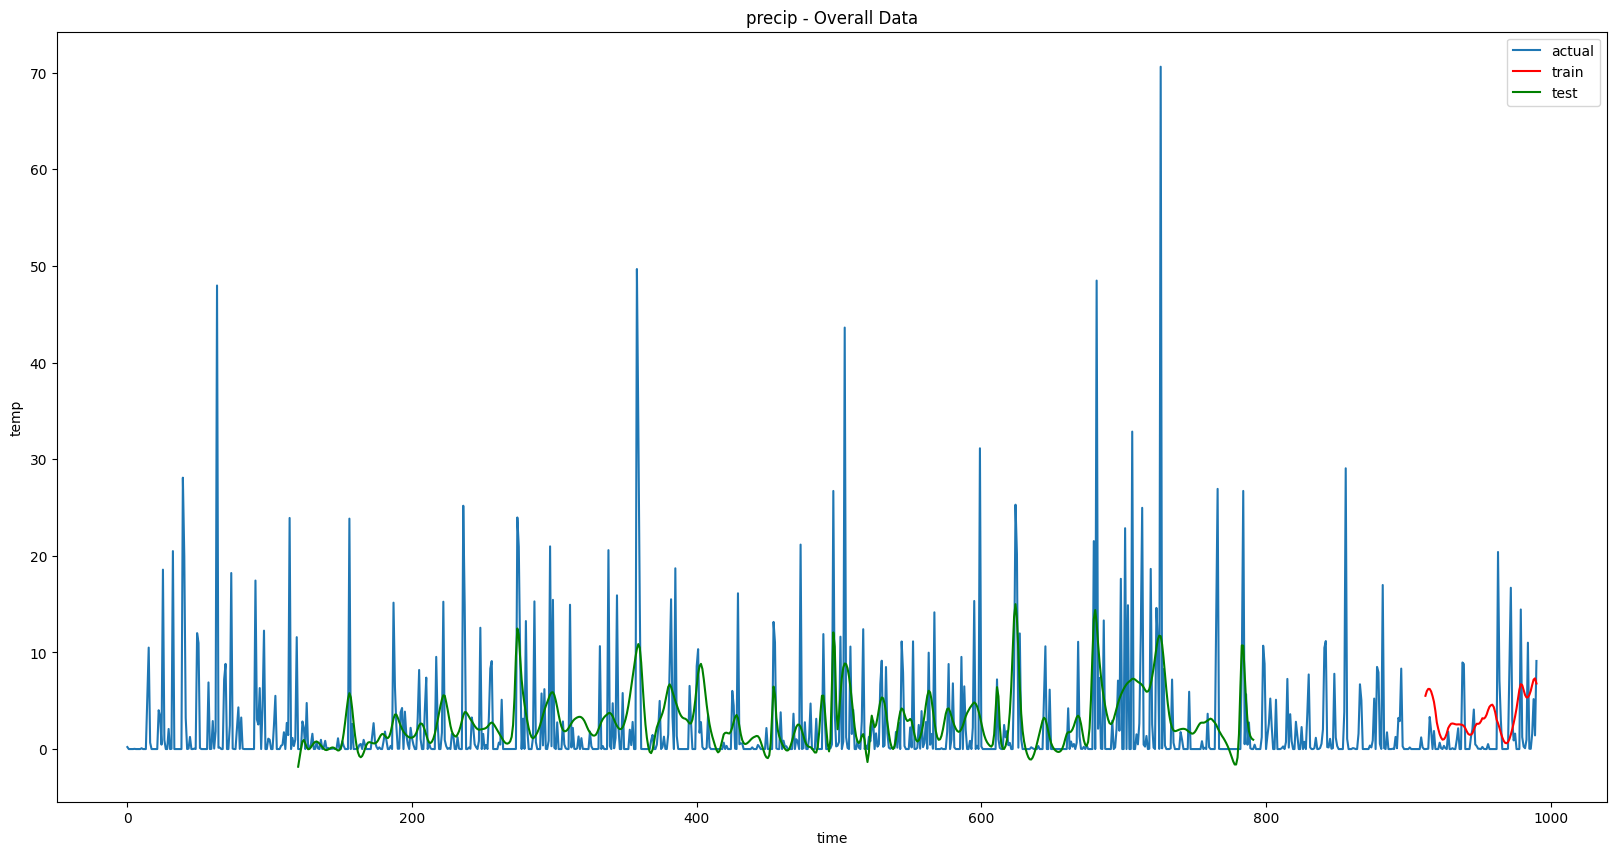

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["precip"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,2],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,2],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('precip - Overall Data')

Text(0.5, 1.0, 'cloudcover - Overall Data')

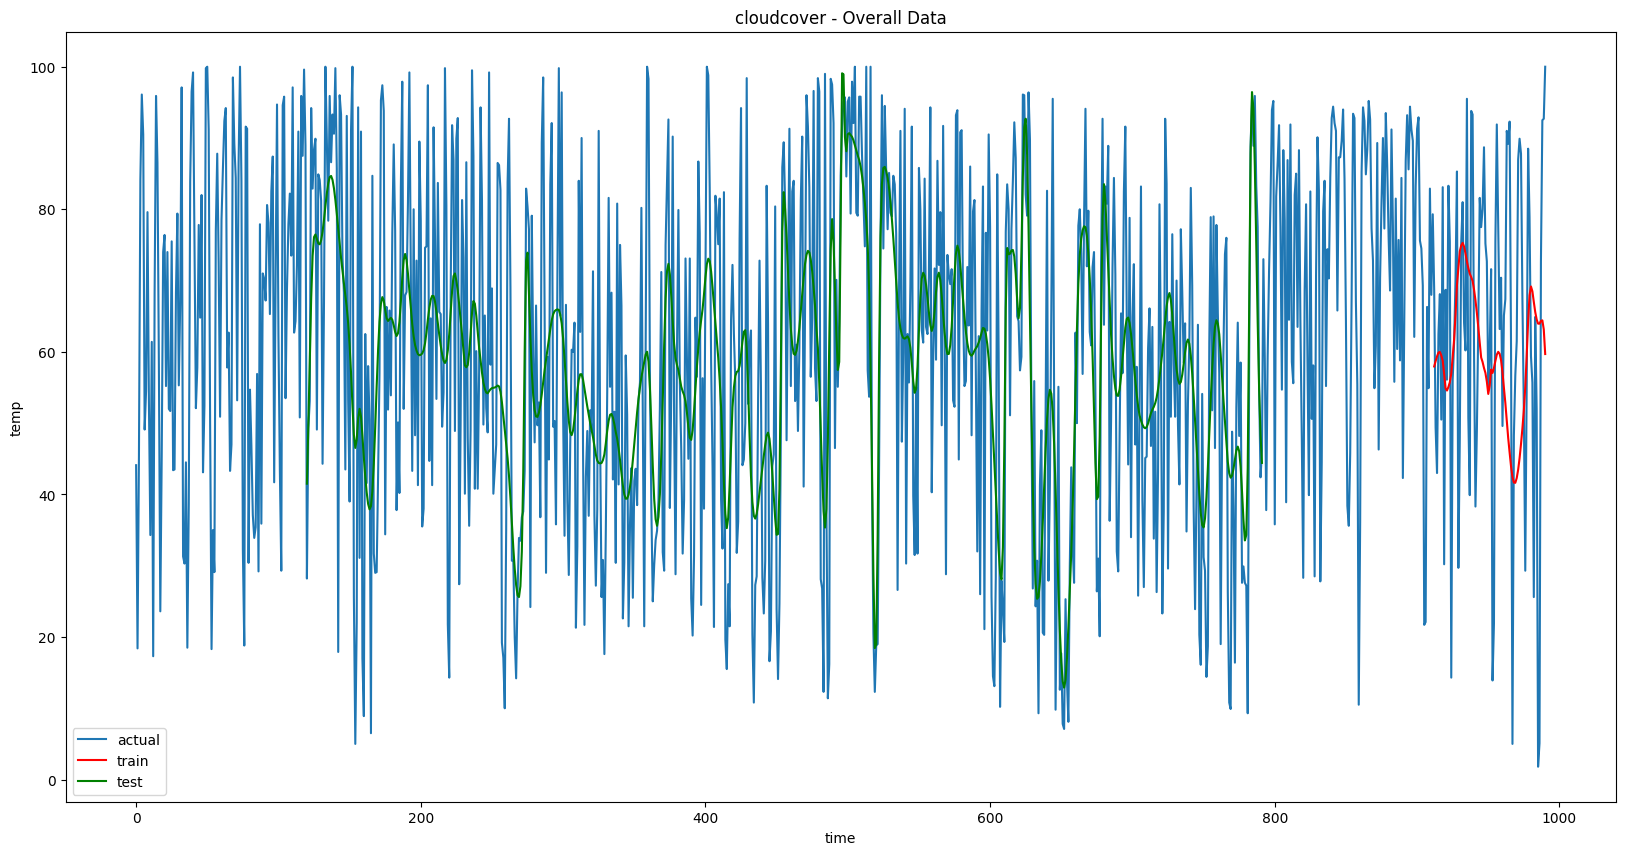

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["cloudcover"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,3],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,3],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('cloudcover - Overall Data')

Text(0.5, 1.0, 'windspeed - Overall Data')

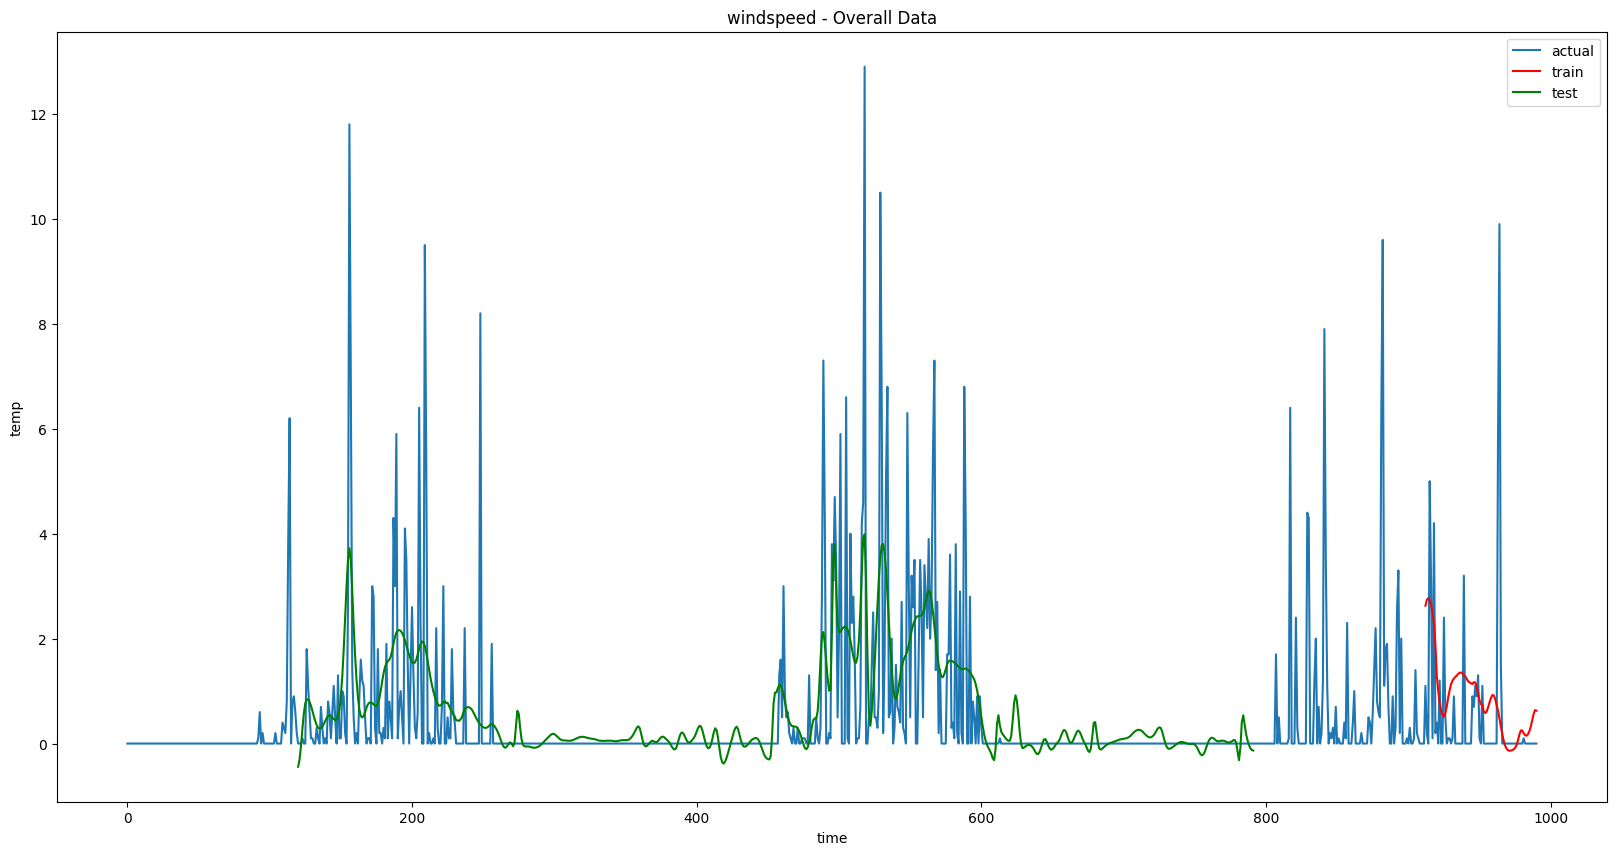

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["snow"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,4],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,4],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('windspeed - Overall Data')

Text(0.5, 1.0, 'windspeed - Overall Data')

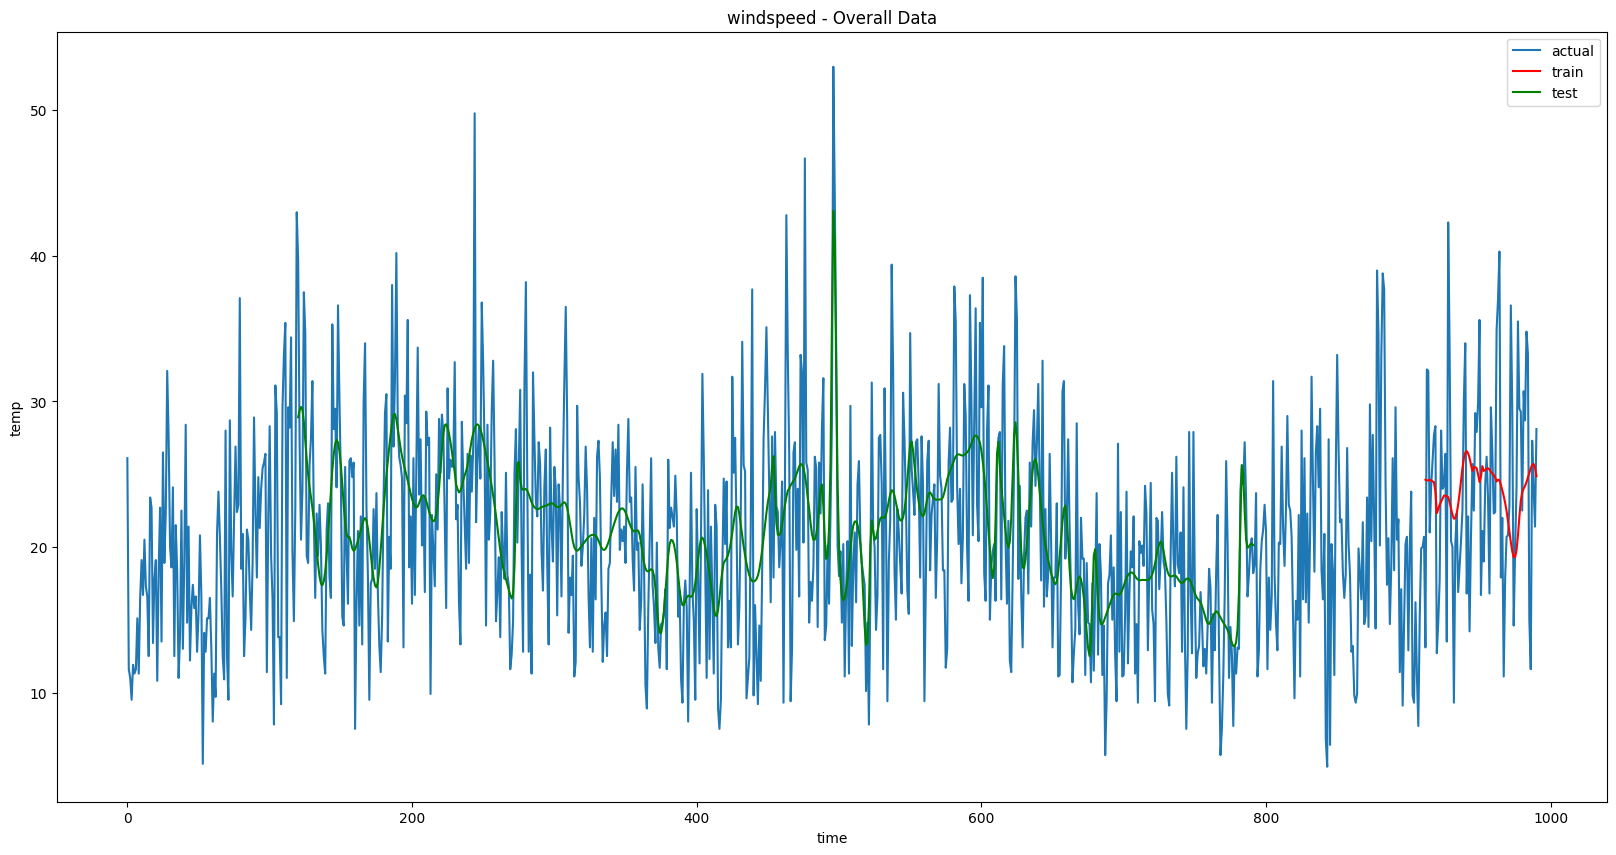

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["windspeed"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,5],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,5],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('windspeed - Overall Data')

Text(0.5, 1.0, 'sealevelpressure - Overall Data')

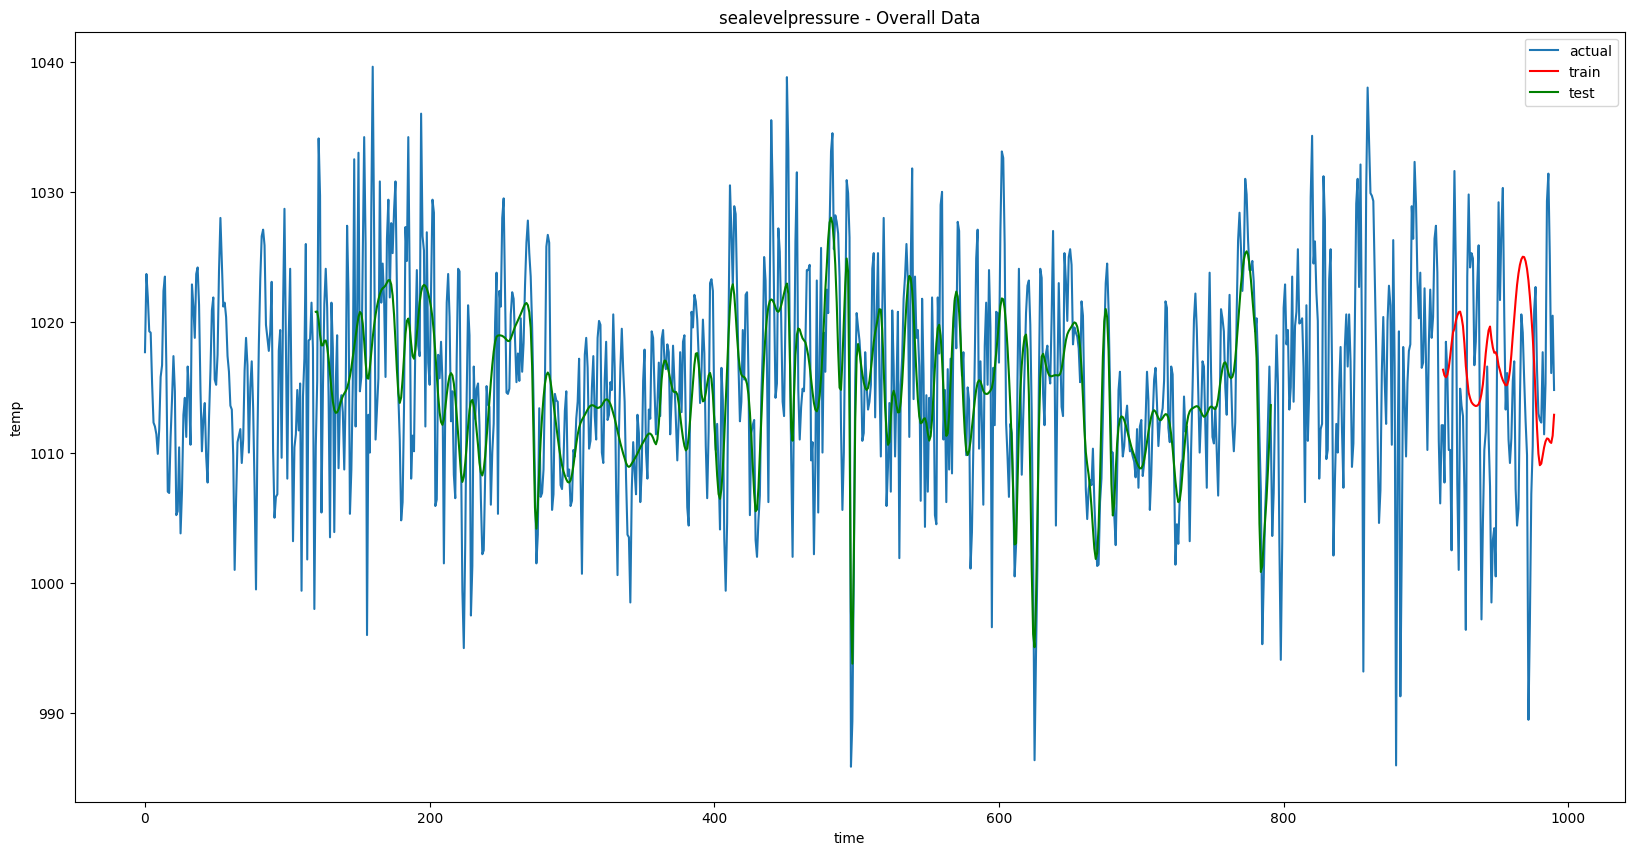

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data["sealevelpressure"])
plt.plot(range(len(data) - unscaled_predicted_vals.shape[0],len(data)),unscaled_predicted_vals[:,6],c = 'r')
plt.plot(range(120,unscaled_predicted_train.shape[0] + 120),unscaled_predicted_train[:,6],c = 'g')
plt.legend(['actual','train','test'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('sealevelpressure - Overall Data')

In [ ]:
with open('model.pkl','wb') as file:
  file.write(pkl.dumps(model))

# Future Forecasting Evaluation
1. data -> jan 02 2024 to april 30 2024 (120 days)
2. 120 days -> past for forecasting
3. current date -> april 30 2024
4. forecasting temperature, humidity, rain, snow, pressure, windspeed, cloud cover for the next 15 days

In [ ]:
future_data_org = pd.read_csv('/content/120 + 15 days test data.csv')
future_data_org = future_data_org.head(120)
future_data_org

name    datetime  tempmax  tempmin  temp  feelslikemax  \
0    Ottawa,Canada  2024-01-02      0.7     -5.8  -2.2          -4.6   
1    Ottawa,Canada  2024-01-03      2.7      0.0   1.0          -0.1   
2    Ottawa,Canada  2024-01-04      0.7    -11.3  -7.5          -2.3   
3    Ottawa,Canada  2024-01-05     -1.8    -12.1  -6.8          -6.0   
4    Ottawa,Canada  2024-01-06     -2.3    -10.2  -8.1          -5.3   
..             ...         ...      ...      ...   ...           ...   
115  Ottawa,Canada  2024-04-26     14.2     -1.9   7.1          14.2   
116  Ottawa,Canada  2024-04-27     19.1      2.8  10.4          19.1   
117  Ottawa,Canada  2024-04-28     20.3      9.7  14.3          20.3   
118  Ottawa,Canada  2024-04-29     11.8      5.7   8.8          11.8   
119  Ottawa,Canada  2024-04-30      8.8      5.9   7.3           5.9   

     feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0           -11.3       -7.4  -6.0      75.6  ...          2.7        2   
1            -3.8       -2.2  -2.1      80.0  ...          1.3        1   
2           -17.1      -13.7 -12.2      69.6  ...          3.6        2   
3           -17.5      -11.5 -10.2      76.7  ...          2.2        1   
4           -19.1      -15.2 -12.5      71.1  ...          1.7        1   
..            ...        ...   ...       ...  ...          ...      ...   
115          -1.9        7.0  -4.6      48.1  ...         24.0        9   
116           0.2        9.6   1.8      58.3  ...         10.8        6   
117           7.9       14.1   9.6      74.6  ...         12.2        8   
118           2.3        7.0   2.0      62.9  ...         12.1        5   
119           2.8        4.3   5.3      87.6  ...          4.7        3   

     severerisk              sunrise               sunset  moonphase  \
0            10  2024-01-02T07:42:44  2024-01-02T16:30:51       0.72   
1            10  2024-01-03T07:42:43  2024-01-03T16:31:49       0.75   
2            10  2024-01-04T07:42:40  2024-01-04T16:32:48       0.78   
3            10  2024-01-05T07:42:33  2024-01-05T16:33:49       0.81   
4            10  2024-01-06T07:42:24  2024-01-06T16:34:52       0.85   
..          ...                  ...                  ...        ...   
115          10  2024-04-26T05:57:58  2024-04-26T20:03:52       0.59   
116          10  2024-04-27T05:56:24  2024-04-27T20:05:09       0.63   
117          10  2024-04-28T05:54:50  2024-04-28T20:06:25       0.67   
118          10  2024-04-29T05:53:18  2024-04-29T20:07:41       0.70   
119          10  2024-04-30T05:51:47  2024-04-30T20:08:57       0.74   

                                     conditions  \
0                              Partially cloudy   
1                              Partially cloudy   
2                        Snow, Partially cloudy   
3                        Snow, Partially cloudy   
4                        Snow, Partially cloudy   
..                                          ...   
115  Snow, Rain, Freezing Drizzle/Freezing Rain   
116                      Rain, Partially cloudy   
117                      Rain, Partially cloudy   
118                              Rain, Overcast   
119                              Rain, Overcast   

                                           description               icon  \
0                    Partly cloudy throughout the day.  partly-cloudy-day   
1                    Partly cloudy throughout the day.  partly-cloudy-day   
2    Partly cloudy throughout the day with early mo...               snow   
3    Partly cloudy throughout the day with late aft...               snow   
4          Partly cloudy throughout the day with snow.               snow   
..                                                 ...                ...   
115  Clear conditions throughout the day with after...               rain   
116        Partly cloudy throughout the day with rain.               rain   
117  Partly cloudy throughout the day with a chance...               rain   


In [ ]:
future_data_org = future_data_org[columns]
future_data_org.head()

datetime  temp  humidity  precip  cloudcover  snow  windspeed  \
0  2024-01-02  -2.2      75.6   0.000        60.9   0.0       23.4   
1  2024-01-03   1.0      80.0   0.000        89.3   0.5       14.5   
2  2024-01-04  -7.5      69.6   0.364        46.3   0.4       29.8   
3  2024-01-05  -6.8      76.7   0.166        70.4   0.0       20.4   
4  2024-01-06  -8.1      71.1   0.885        81.0   2.3       27.7   

   sealevelpressure  
0            1015.5  
1            1012.2  
2            1020.1  
3            1022.8  
4            1021.3

In [ ]:
future_data_org.shape

(120, 8)

In [ ]:
pred_data = future_data_org.copy()

In [ ]:
pred_data.drop('datetime',axis = 1,inplace = True)

In [ ]:
scaled_pred_data = scale.transform(pred_data)
scaled_pred_data = pd.DataFrame(scaled_pred_data)
scaled_pred_data

0         1         2         3         4         5         6
0    0.441634  0.649560  0.000000  0.588421  0.000000  0.382046  0.551210
1    0.503891  0.714076  0.000000  0.887368  0.038760  0.196242  0.489758
2    0.338521  0.561584  0.005155  0.434737  0.031008  0.515658  0.636872
3    0.352140  0.665689  0.002351  0.688421  0.000000  0.319415  0.687151
4    0.326848  0.583578  0.012532  0.800000  0.178295  0.471816  0.659218
..        ...       ...       ...       ...       ...       ...       ...
115  0.622568  0.246334  0.000326  0.001053  0.000000  0.135699  0.847300
116  0.686770  0.395894  0.031324  0.695789  0.000000  0.463466  0.729981
117  0.762646  0.634897  0.043729  0.869474  0.000000  0.394572  0.562384
118  0.655642  0.463343  0.020009  0.923158  0.000000  0.340292  0.644320
119  0.626459  0.825513  0.129091  1.000000  0.000000  0.480167  0.538175

[120 rows x 7 columns]

In [ ]:
# last 15 values of temp attribute are made nan since these are the values required to be forecasted
#scaled_pred_data.iloc[120:,[0]] = np.nan
#scaled_pred_data

In [ ]:
def future_prediction(df,step):
  lst_output = []
  future_val = df.values
  future_val = future_val.tolist()
  #print(future_val)
  for _ in range(timestamp,step+timestamp):
    if len(future_val) > timestamp:
      x_input = np.array(future_val[1:])
      #x_input = x_input.reshape(1,-1)
      print(x_input.shape)
      x_input = x_input.reshape(1, timestamp, 7)
      pred= model.predict(x_input)
      future_val.extend(pred.tolist())
      future_val = future_val[1:]
      lst_output.extend(pred)

    else:
      #print(df.shape)
      x_input = df.values.reshape(1, timestamp,7)
      #print(x_input.shape)
      pred = model.predict(x_input)
      future_val.extend(pred.tolist())
      lst_output.extend(pred)

  return lst_output

future_pred = future_prediction(scaled_pred_data,15)
#future_pred = np.array(future_pred).reshape(15,7)
future_pred = np.array(future_pred)


1/1 [==============================] - 0s 69ms/step
(120, 7)
1/1 [==============================] - 0s 71ms/step
(120, 7)
1/1 [==============================] - 0s 64ms/step
(120, 7)
1/1 [==============================] - 0s 74ms/step
(120, 7)
1/1 [==============================] - 0s 80ms/step
(120, 7)
1/1 [==============================] - 0s 81ms/step
(120, 7)
1/1 [==============================] - 0s 74ms/step
(120, 7)
1/1 [==============================] - 0s 73ms/step
(120, 7)
1/1 [==============================] - 0s 82ms/step
(120, 7)
1/1 [==============================] - 0s 72ms/step
(120, 7)
1/1 [==============================] - 0s 76ms/step
(120, 7)
1/1 [==============================] - 0s 81ms/step
(120, 7)
1/1 [==============================] - 0s 78ms/step
(120, 7)
1/1 [==============================] - 0s 76ms/step
(120, 7)
1/1 [==============================] - 0s 69ms/step


In [ ]:
future_pred.shape

(15, 7)

In [ ]:
future_pred[0]

array([0.688788  , 0.6084275 , 0.0833977 , 0.5249994 , 0.04356069,
       0.39753255, 0.5379269 ], dtype=float32)

In [ ]:
unscaled_pred = scale.inverse_transform(future_pred)
unscaled_pred

array([[ 1.05037031e+01,  7.27947617e+01,  5.88929558e+00,
         5.48749390e+01,  5.61932921e-01,  2.41418095e+01,
         1.01478668e+03],
       [ 1.07804241e+01,  6.91179123e+01,  4.37572432e+00,
         4.76378021e+01,  3.97089690e-01,  2.33773365e+01,
         1.01763306e+03],
       [ 1.12694111e+01,  6.47072525e+01,  2.95265985e+00,
         4.02458992e+01,  2.31304318e-01,  2.28456173e+01,
         1.01984186e+03],
       [ 1.20701771e+01,  6.00223465e+01,  1.75762749e+00,
         3.35291595e+01,  7.93143362e-02,  2.24443893e+01,
         1.02110107e+03],
       [ 1.31728382e+01,  5.54704933e+01,  8.08901012e-01,
         2.80001297e+01, -4.93472517e-02,  2.21028786e+01,
         1.02158429e+03],
       [ 1.45294104e+01,  5.13144836e+01,  5.63540123e-02,
         2.39005413e+01, -1.54851198e-01,  2.18024998e+01,
         1.02150903e+03],
       [ 1.59710245e+01,  4.79469185e+01, -5.40507436e-01,
         2.15089836e+01, -2.42991567e-01,  2.15677738e+01,
         1.0209862

Text(0.5, 1.0, 'temp - Future Forecasting')

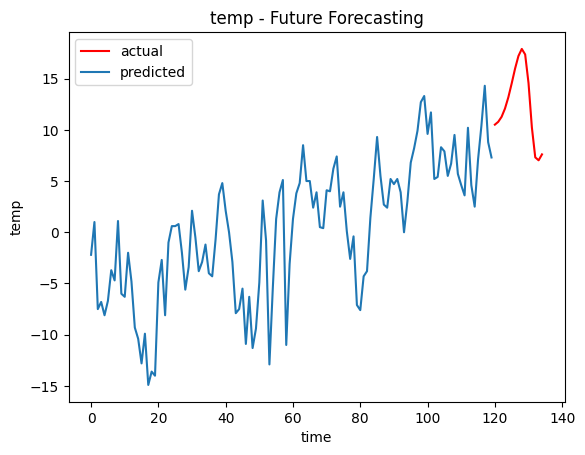

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,0], c = 'r')
plt.plot(future_data_org['temp'])
plt.legend(['actual','predicted'])
plt.ylabel('temp')
plt.xlabel('time')
plt.title('temp - Future Forecasting')

Text(0.5, 1.0, 'humidity - Future Forecasting')

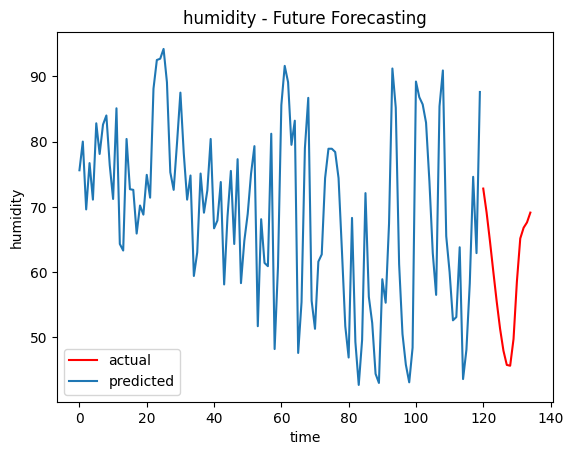

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,1], c = 'r')
plt.plot(future_data_org['humidity'])
plt.legend(['actual','predicted'])
plt.ylabel('humidity')
plt.xlabel('time')
plt.title('humidity - Future Forecasting')

Text(0.5, 1.0, 'precicpitation - Future Forecasting')

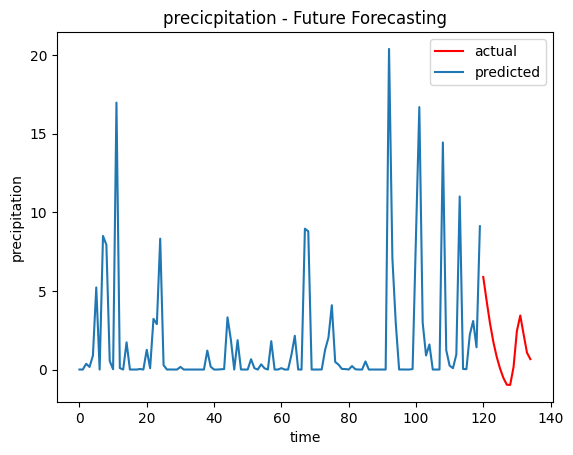

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,2], c = 'r')
plt.plot(future_data_org['precip'])
plt.legend(['actual','predicted'])
plt.ylabel('precipitation')
plt.xlabel('time')
plt.title('precicpitation - Future Forecasting')

Text(0.5, 1.0, 'cloud cover - Future Forecasting')

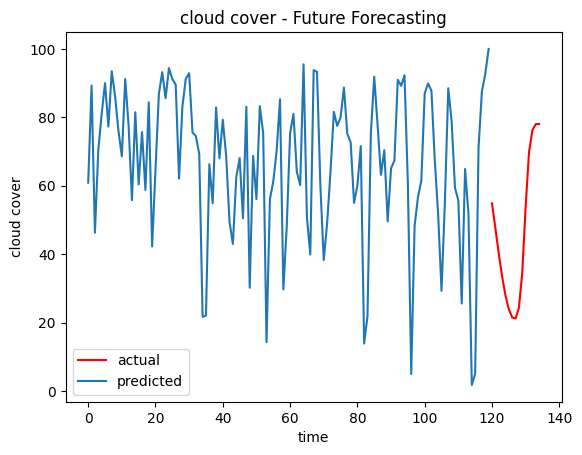

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,3], c = 'r')
plt.plot(future_data_org['cloudcover'])
plt.legend(['actual','predicted'])
plt.ylabel('cloud cover')
plt.xlabel('time')
plt.title('cloud cover - Future Forecasting')

Text(0.5, 1.0, 'snow - Future Forecasting')

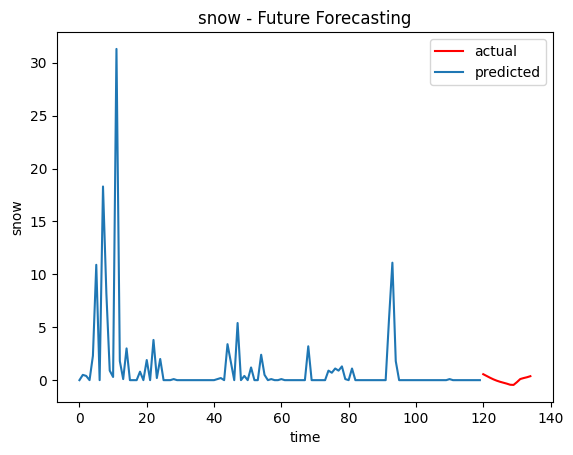

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,4], c = 'r')
plt.plot(future_data_org['snow'])
plt.legend(['actual','predicted'])
plt.ylabel('snow')
plt.xlabel('time')
plt.title('snow - Future Forecasting')

Text(0.5, 1.0, 'windspeed - Future Forecasting')

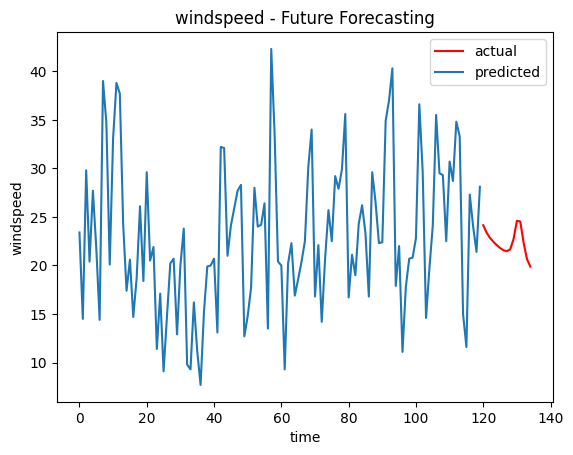

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,5], c = 'r')
plt.plot(future_data_org['windspeed'])
plt.legend(['actual','predicted'])
plt.ylabel('windspeed')
plt.xlabel('time')
plt.title('windspeed - Future Forecasting')

Text(0.5, 1.0, 'pressure - Future Forecasting')

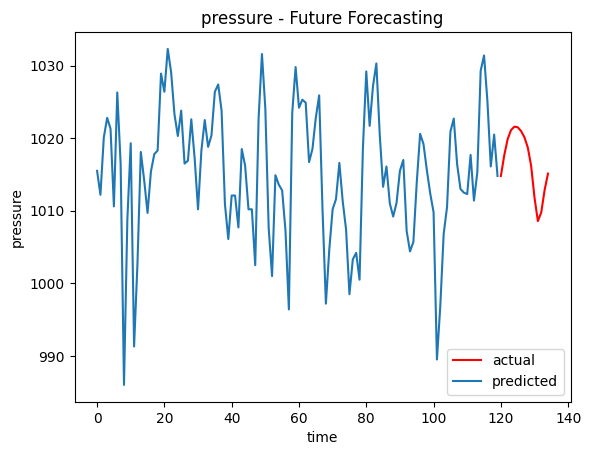

In [ ]:
plt.plot(range(120,135),unscaled_pred[:,6], c = 'r')
plt.plot(future_data_org['sealevelpressure'])
plt.legend(['actual','predicted'])
plt.ylabel('pressure')
plt.xlabel('time')
plt.title('pressure - Future Forecasting')